#Stock Recommendataion for Portfolio Optimization 

---



#**AML Group 23**

Team Members

Dominic Insogna (dmi2116) 

Vritansh Kamal (vk2501) 

Turner Mandeville (tmm2169) 

Yan Gong (yg2818) 

Ruoyu Chen (rc3506)

#Introduction

The goal of the project is to evaulate multiple models to come up with a stocks reccomendataion system. For this we've considered top 10 stock weightes from S&P500. These stocks are then evaluated against each of the ML models with below technical indicators. The choice of technical indicators is a result of research and development across multiple research papers and trial and error methods. The models are then trained and compared on their performance on the test and train dataset. 

Most of our models are trying to solve binary classification problem defined as below: 
1. If the Adj. Close price on Friday > Adj. Close on Monday : We labeled it as "1" for action "Buy" 

2. If the Adj. Close price on Friday < Adj. Close on Monday : We labeled it as "0" for action "Sell" 

Our Ensemble model is used to finally used to compute the best performing model for below classification techniques:- 
1. Random Forests 
2. Logistic Regression
3. Boosting
4. SVC 

Since stock prices are highly time-dependent, we also considered LSTM model as an option to solve our problem, as it could predict future values based on previous sequential data and allow more parameters to be learned and contained in the model than other neural networks by adding long-term memory. However, LSTM returns numerical values (predicted future stock prices) instead of suggestion labels (buy or sell), which makes it hard to be included in the ensembled model. LSTM also has other issues, such as heavy computing power requirement (a fresh LSTM model needs to be trained and tested each time when a new individual stock is picked) and training data reliability (longer duration of stock price history may differ the result). 

**Assumptions**

Below stock data has been considered 

Start Date for dataset - 1st April 2021

End Date for dataset - 1st December 2022

# Imports

In [ ]:
#Install Required Libraries
!pip install yfinance
!pip install ta
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Imports 
import pandas as pd
import ta as ta
import numpy as np 
from datetime import datetime
from sklearn.metrics import accuracy_score

import pandas_datareader as pdr
import yfinance as yfin
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, date
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, ParameterGrid, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from collections import Counter

from sklearn import metrics
from sklearn.metrics import accuracy_score, r2_score, classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

from tqdm import tqdm

from tensorflow import keras
from tensorflow.keras import layers

#Hide runtime warnings 
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing




In [ ]:
# Define the list of tickers
tickers = [
'AAPL',
'MSFT',
'AMZN',
'TSLA',
'BRK-B',
'UNH',
'GOOGL',
'XOM',
'JNJ',
'JPM',
]

#Download data
stocks = []
for ticker in tickers:
    stocks.append(yfin.download(ticker, start="2021-04-01", end="2022-12-01")) #1.5 years of time series data

#Add technical indicators
feature_names = ['RSI', 'SO', 'SMA', 'MACD', 'ROC', 'OBV']
for data in stocks:  
    #RSI Indicator: Relative Strength Index
    data['RSI'] = ta.momentum.RSIIndicator(data['Adj Close'], window=14, fillna=True).rsi()
    #Stochastic Oscillator
    data['SO'] = ta.momentum.StochRSIIndicator(data['Adj Close'], window=14, fillna=True).stochrsi()
    #Simple MOving Average
    data['SMA'] = ta.trend.sma_indicator(data['Adj Close'], window=14, fillna=True)
    #MACD
    data['MACD'] = ta.trend.macd(data['Adj Close'], window_slow = 26, window_fast = 12, fillna=True)
    # ROC Rate of Change (momentum)
    data['ROC'] = ta.momentum.ROCIndicator(data['Adj Close'], window=14, fillna=True).roc()
    #OBV: On Balance Volume
    data['OBV'] = ta.volume.OnBalanceVolumeIndicator(close=data['Adj Close'], volume=data['Volume'], fillna=True).on_balance_volume()

# Add labels:
# Buy (1): Positive change in price (>= 0)  
# Sell (0): Negative change in price (< 0)   
for stock in stocks:
    stock['5d_change_in_price'] = stock['Adj Close'].diff(-5)*-1
    stock['5d_label'] = stock['5d_change_in_price'].apply(lambda x: 1 if x >= 0 else 0)
    stock['20d_change_in_price'] = stock['Adj Close'].diff(-20)*-1
    stock['20d_label'] = stock['20d_change_in_price'].apply(lambda x: 1 if x >= 0 else 0)

#Preprocessing and Scaling: 5 day prediction
X_train_5d = []
y_train_5d = []
X_test_5d = []
y_test_5d = []

for stock in stocks:
    # Any row that has a `NaN` value will be dropped.
    stock = stock.dropna()    

    # train test split
    X = stock[feature_names]
    y = stock['5d_label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    #If we want validation data use this code instead:
    # X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    # X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.2, random_state=42, shuffle=False)

    # Scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # store data for each stock
    X_train_5d.append(X_train)
    y_train_5d.append(y_train)
    X_test_5d.append(X_test)
    y_test_5d.append(y_test)

#Preprocessing and Scaling: 20 day prediction
X_train_20d = []
y_train_20d = []
X_test_20d = []
y_test_20d = []

for stock in stocks:
    # Any row that has a `NaN` value will be dropped.
    stock = stock.dropna()    

    # train test split
    X = stock[feature_names]
    y = stock['20d_label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    #If we want validation data use this code instead:
    # X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    # X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.2, random_state=42, shuffle=False)

    # Scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    #store data for each stock
    X_train_20d.append(X_train)
    y_train_20d.append(y_train)
    X_test_20d.append(X_test)
    y_test_20d.append(y_test)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
print(len(X_train_5d))
print(len(y_train_5d))
print(len(X_test_5d))
print(len(y_test_5d))
print(stock.shape)

10
10
10
10
(401, 16)


#Data Visualizations

3.2.2


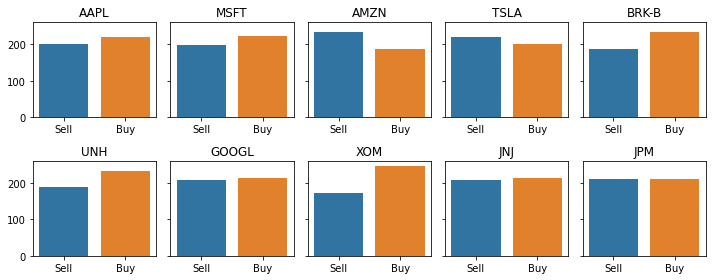

In [ ]:
import matplotlib
print(matplotlib.__version__) #3.2.2 - OLD
y_5d = [stock['5d_label'] for stock in stocks]

# Simple distribution counts
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4), sharey=True)
for stock, stock_y5d, ax in zip(tickers, y_5d, axes.flatten()):
    distribution_5d = stock_y5d.value_counts()
    ax = sns.barplot(x=distribution_5d.index, y=distribution_5d.values, ax=ax)
    ax.set_title(stock)
    # ax.set_xticks([0,1], labels=['Sell', 'Buy']) # [0,1] # not compatible with matplotlib version 3.2.2
    ax.set_xticks([0,1])
    ax.set_xticklabels(labels=['Sell', 'Buy'])
    # print(distribution_5d)

# fig.suptitle('Label Distribution') # eithr collab or matplotlib 3.2.2 doesn't like this
fig.tight_layout()


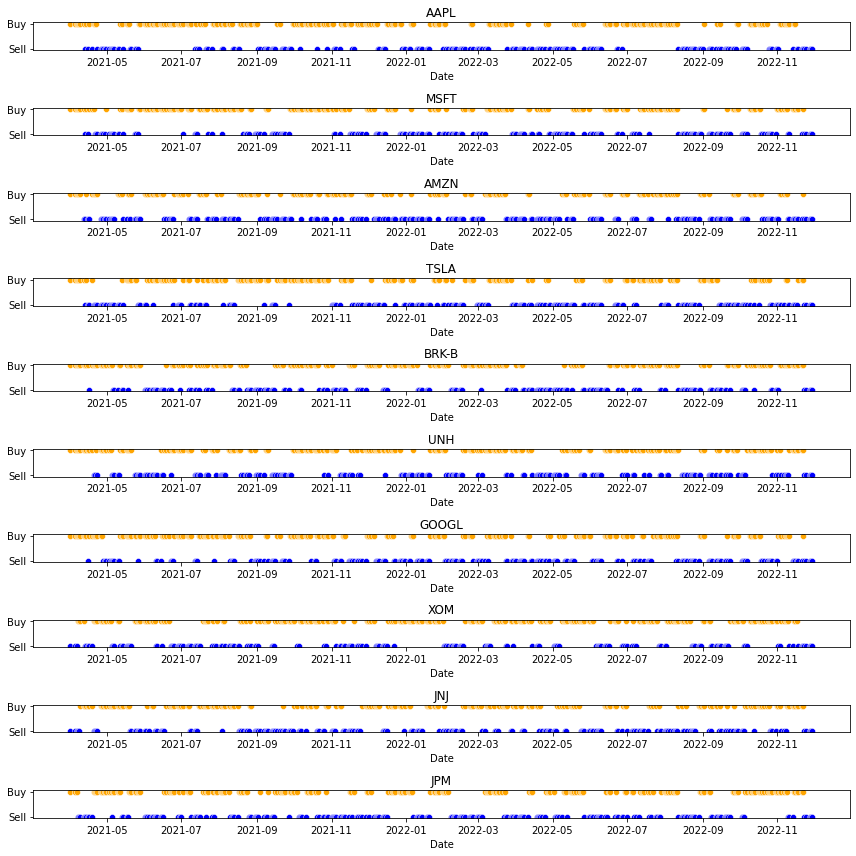

In [ ]:
# Distribution over time
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(12,12))
for stock, stock_y_5d, ax in zip(tickers, y_5d, axes.flatten()):
    y_up = stock_y_5d[stock_y_5d == 1]
    xs_up = y_up.index
    ys_up = np.ones(len(xs_up))
    sns.scatterplot(x=xs_up, y=ys_up, color='orange', ax=ax)

    y_down = stock_y_5d[stock_y_5d == 0]
    xs_down = y_down.index
    ys_down = np.zeros(len(xs_down))
    sns.scatterplot(x=xs_down, y=ys_down, color='blue', ax=ax)

    ax.set_title(stock)
    ax.set_yticks([0,1])
    ax.set_yticklabels(labels=['Sell', 'Buy'])

fig.tight_layout()

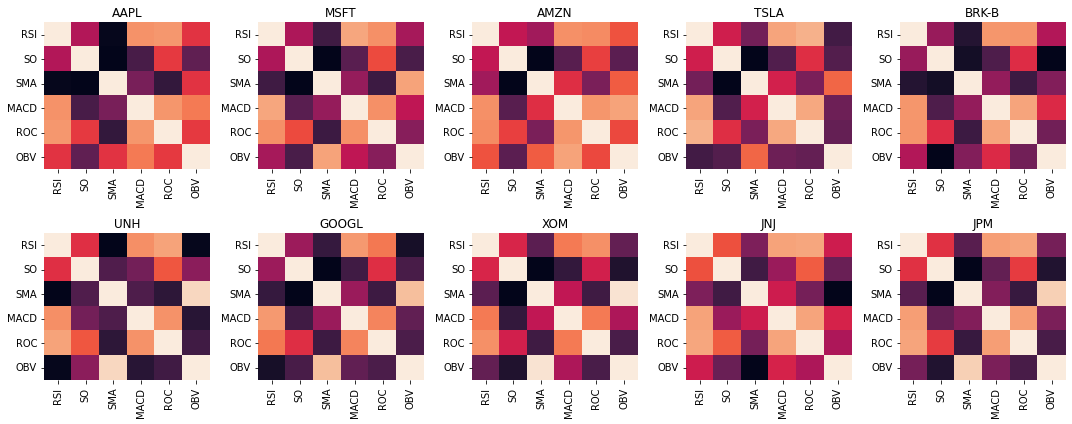

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15,6))

for stock, stock_data, ax in zip(tickers, stocks, axes.flatten()):
  # short_names = [name[:20] for name in historical_data.columns]
  # sns.heatmap(historical_data.corr(), xticklabels=short_names, yticklabels=short_names, ax=ax, cbar=False)
  stock_X_5d = stock_data[feature_names]
  sns.heatmap(stock_X_5d.corr(), ax=ax, cbar=False)
  ax.set_title(stock)

# fig.suptitle('Feature Correlations')
fig.tight_layout()

#Different ML Models

###Support Vector Machines (Vritansh Kamal vk2501) 

In [ ]:
#5 day predictions
clf = SVC(probability=True, kernel="linear")

#Using below paramters for the model
param_grid = {'C': [0.1 ], 
                      'gamma': [1],
                      'kernel': ['linear']} 

clf = GridSearchCV(SVC(), param_grid, refit = True, verbose = 0)
stocks_metrics = []
print("5 Days Period")
for i, stock in enumerate(stocks):
    X_train = X_train_5d[i]
    y_train = y_train_5d[i]
    X_test = X_test_5d[i]
    y_test = y_test_5d[i]
    #Fit the classifier here
    clf.fit(X_train, y_train)
    #Get the best estimator from the grid search
    svm = clf.best_estimator_
    y_pred = svm.predict(X_test)
    #compute metrics
    
    temp = {}
    temp['best_estimator'] = svm
    temp['symbol']  = tickers[i]
    # temp["accuracy_score_val"] = accuracy_score(y_val, y_pred_val)
    temp["accuracy_score_test"] = accuracy_score(y_test, y_pred)
    #Build dictionary of features and store them
    temp["feature_importances"] = svm.coef_
    temp["all_features"] = dict(zip(feature_names, temp["feature_importances"][0]))
    temp["sorted_features"] = sorted(temp["all_features"].items(), key=lambda x: x[1])  
    stocks_metrics.append(temp.copy())
    info = "Stock : " + str(tickers[i]) + " | Accuracy Score " + str(temp['accuracy_score_test'])
    # print(grid.best_score_)
    print(info)

all_metrics_svc = {}
all_metrics_svc['5_day_metrics'] = stocks_metrics.copy()
stocks_metrics = []

print("20 Day Period")
for i, stock in enumerate(stocks):
    X_train = X_train_20d[i]
    y_train = y_train_20d[i]
    X_test = X_test_20d[i]
    y_test = y_test_20d[i]
    #Fit the classifier here
    clf.fit(X_train, y_train)
    #Get best estimator for the model 
    svm = clf.best_estimator_
    y_pred = svm.predict(X_test)

    temp = {}
    temp['best_estimator'] = svm
    temp['symbol']  = tickers[i]
    # temp["accuracy_score_val"] = accuracy_score(y_val, y_pred_val)
    temp["accuracy_score_test"] = accuracy_score(y_test, y_pred)
    #Build dictionary of features and store them
    temp["feature_importances"] = svm.coef_
    temp["all_features"] = dict(zip(feature_names, temp["feature_importances"][0]))
    temp["sorted_features"] = sorted(temp["all_features"].items(), key=lambda x: x[1])  
    stocks_metrics.append(temp.copy())
    info = "Stock : " + str(tickers[i]) + " | Accuracy Score " + str(temp['accuracy_score_test'])
    print(info)

all_metrics_svc['20_day_metrics'] = stocks_metrics.copy()

5 Days Period
Stock : AAPL | Accuracy Score 0.7160493827160493
Stock : MSFT | Accuracy Score 0.3950617283950617
Stock : AMZN | Accuracy Score 0.5432098765432098
Stock : TSLA | Accuracy Score 0.5308641975308642
Stock : BRK-B | Accuracy Score 0.5432098765432098
Stock : UNH | Accuracy Score 0.5555555555555556
Stock : GOOGL | Accuracy Score 0.4074074074074074
Stock : XOM | Accuracy Score 0.6790123456790124
Stock : JNJ | Accuracy Score 0.5432098765432098
Stock : JPM | Accuracy Score 0.5308641975308642
20 Day Period
Stock : AAPL | Accuracy Score 0.7283950617283951
Stock : MSFT | Accuracy Score 0.37037037037037035
Stock : AMZN | Accuracy Score 0.30864197530864196
Stock : TSLA | Accuracy Score 0.49382716049382713
Stock : BRK-B | Accuracy Score 0.5679012345679012
Stock : UNH | Accuracy Score 0.5555555555555556
Stock : GOOGL | Accuracy Score 0.2839506172839506
Stock : XOM | Accuracy Score 0.8395061728395061
Stock : JNJ | Accuracy Score 0.5679012345679012
Stock : JPM | Accuracy Score 0.3703703703

In [ ]:
#Tuning Hyperparams
clf = SVC(probability=True, kernel="linear")
#Defining multiple hyperparams here
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
                      'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                      'kernel': ['linear']} 
ts_cv_svc = TimeSeriesSplit(
        n_splits=5,
        gap=0,
    )
clf = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1, cv= ts_cv_svc)

print("***************** 5 Day Period ***********")
stocks_metrics = []
for i, stock in enumerate(stocks):
    X_train = X_train_5d[i]
    y_train = y_train_5d[i]
    X_test = X_test_5d[i]
    y_test = y_test_5d[i]
    #Fit the classifier here
    clf.fit(X_train, y_train)
    #Get best estimator for the model 
    svm = clf.best_estimator_
    y_pred = svm.predict(X_test)
    #compute metrics
    temp = {}
    temp['best_estimator'] = svm
    temp['symbol']  = tickers[i]
    temp["accuracy_score_test"] = accuracy_score(y_test, y_pred)
    #Build dictionary of features and store them
    temp["feature_importances"] = svm.coef_
    temp["all_features"] = dict(zip(feature_names, temp["feature_importances"][0]))
    temp["sorted_features"] = sorted(temp["all_features"].items(), key=lambda x: x[1])  
    stocks_metrics.append(temp.copy())
    info = "Stock : " + str(tickers[i]) + " | Accuracy Score " + str(temp['accuracy_score_test'])
    # print(grid.best_score_)
    print(info)


all_metrics_svc = {}
all_metrics_svc['5_day_metrics'] = stocks_metrics.copy()
stocks_metrics = []

print("***************** 20 Day Period ***********")

for i, stock in enumerate(stocks):
    X_train = X_train_20d[i]
    y_train = y_train_20d[i]
    X_test = X_test_20d[i]
    y_test = y_test_20d[i]
    #Fit the classifier here
    clf.fit(X_train, y_train)
    #Get best estimator for the model 
    svm = clf.best_estimator_
    y_pred = svm.predict(X_test)
    #compute metrics
    temp = {}
    temp['best_estimator'] = svm
    temp['symbol']  = tickers[i]

    temp["accuracy_score_test"] = accuracy_score(y_test, y_pred)
    #Build dictionary of features and store them
    temp["feature_importances"] = svm.coef_
    temp["all_features"] = dict(zip(feature_names, temp["feature_importances"][0]))
    temp["sorted_features"] = sorted(temp["all_features"].items(), key=lambda x: x[1])  
    stocks_metrics.append(temp.copy())

    info = "Stock : " + str(tickers[i]) + " | Accuracy Score " + str(temp['accuracy_score_test'])
    # print(grid.best_score_)
    print(info)

all_metrics_svc['20_day_metrics'] = stocks_metrics.copy()

***************** 5 Day Period ***********
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Stock : AAPL | Accuracy Score 0.7160493827160493
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Stock : MSFT | Accuracy Score 0.3950617283950617
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Stock : AMZN | Accuracy Score 0.5432098765432098
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Stock : TSLA | Accuracy Score 0.5308641975308642
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Stock : BRK-B | Accuracy Score 0.5432098765432098
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Stock : UNH | Accuracy Score 0.5679012345679012
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Stock : GOOGL | Accuracy Score 0.4074074074074074
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Stock : XOM | Accuracy Score 0.6172839506172839
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Stock :

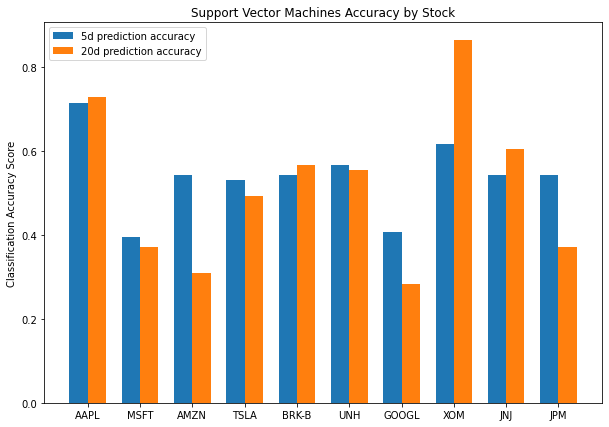

In [ ]:
scores_5d_svc = []
scores_20d_svc = []

for i,metric in enumerate(all_metrics_svc['5_day_metrics']):
      scores_5d_svc.append(all_metrics_svc['5_day_metrics'][i]['accuracy_score_test'])   
      scores_20d_svc.append(all_metrics_svc['20_day_metrics'][i]['accuracy_score_test'])   

labels = tickers

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
plt.figure(figsize=(10,7))
# fig, ax = plt.subplots()
rects1 = plt.bar(x - width/2, scores_5d_svc, width, label='5d prediction accuracy')
rects2 = plt.bar(x + width/2, scores_20d_svc, width, label='20d prediction accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('Classification Accuracy Score')
plt.title('Support Vector Machines Accuracy by Stock')
plt.xticks(x, labels)
plt.legend()
plt.show()

In [ ]:
#Metrics For Calculation of Classiication Report
for i,metric in enumerate(all_metrics_svc['5_day_metrics']):
      y_pred = all_metrics_svc['5_day_metrics'][i]['best_estimator'].predict(X_test_5d[i])
      print("5d Classification Report for", tickers[i])
      report = classification_report(y_true = y_test_20d[i], y_pred = y_pred, target_names = ['down','up'], output_dict = True)
      report_df = pd.DataFrame(report).transpose()
      print(report_df)
      print()

5d Classification Report for AAPL
              precision    recall  f1-score    support
down           0.921053  0.700000  0.795455  50.000000
up             0.651163  0.903226  0.756757  31.000000
accuracy       0.777778  0.777778  0.777778   0.777778
macro avg      0.786108  0.801613  0.776106  81.000000
weighted avg   0.817761  0.777778  0.780644  81.000000

5d Classification Report for MSFT
              precision    recall  f1-score    support
down           1.000000  0.235294  0.380952  51.000000
up             0.434783  1.000000  0.606061  30.000000
accuracy       0.518519  0.518519  0.518519   0.518519
macro avg      0.717391  0.617647  0.493506  81.000000
weighted avg   0.790660  0.518519  0.464326  81.000000

5d Classification Report for AMZN
              precision    recall  f1-score    support
down           0.790123  1.000000  0.882759  64.000000
up             0.000000  0.000000  0.000000  17.000000
accuracy       0.790123  0.790123  0.790123   0.790123
macro avg      0

In [ ]:
#Metrics For Calculation of Classification Report
for i,metric in enumerate(all_metrics_svc['20_day_metrics']):
      y_pred = all_metrics_svc['20_day_metrics'][i]['best_estimator'].predict(X_test_20d[i])
      print("20d Classification Report for", tickers[i])
      report = classification_report(y_true = y_test_20d[i], y_pred = y_pred, target_names = ['down','up'], output_dict = True)
      report_df = pd.DataFrame(report).transpose()
      print(report_df)
      print()

20d Classification Report for AAPL
              precision    recall  f1-score    support
down           1.000000  0.560000  0.717949  50.000000
up             0.584906  1.000000  0.738095  31.000000
accuracy       0.728395  0.728395  0.728395   0.728395
macro avg      0.792453  0.780000  0.728022  81.000000
weighted avg   0.841137  0.728395  0.725659  81.000000

20d Classification Report for MSFT
              precision   recall  f1-score   support
down           0.000000  0.00000  0.000000  51.00000
up             0.370370  1.00000  0.540541  30.00000
accuracy       0.370370  0.37037  0.370370   0.37037
macro avg      0.185185  0.50000  0.270270  81.00000
weighted avg   0.137174  0.37037  0.200200  81.00000

20d Classification Report for AMZN
              precision    recall  f1-score    support
down           0.666667  0.250000  0.363636  64.000000
up             0.157895  0.529412  0.243243  17.000000
accuracy       0.308642  0.308642  0.308642   0.308642
macro avg      0.412281  

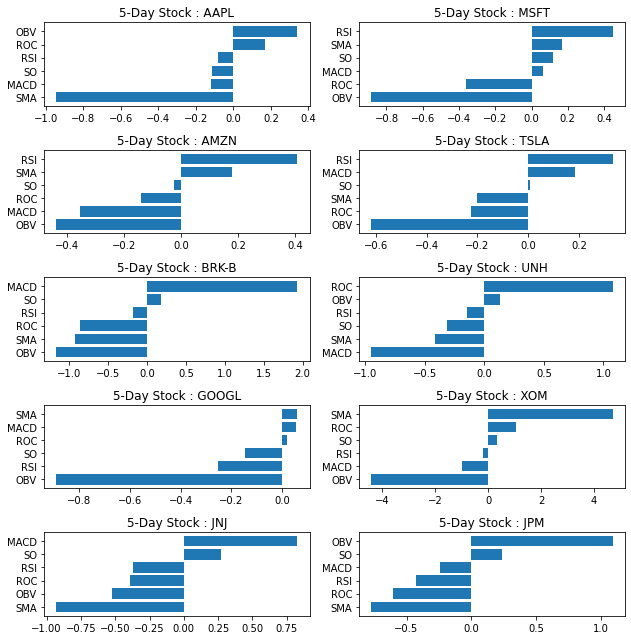

In [ ]:
#Features Importances 
#convert into data frame for pandas
df_metrics = pd.DataFrame(all_metrics_svc['20_day_metrics'])
# Features importance for each stock
fig, axs = plt.subplots( 5, 2, figsize=(9,9))
row =0 
column = 0

for  metric in (all_metrics_svc['5_day_metrics']):
    title =  "5-Day " + "Stock : " +  metric["symbol"]
    # Plot Accuracy Score for Each of the features 
    temp_list_values = []
    temp_list_features = []
    # Plot Features Importances 
    for i in metric["sorted_features"]:
        temp_list_values.append(i[1])
        temp_list_features.append(i[0])
    # axs[row, column].barh(features_names , metric["feature_importances"][0])
    axs[row, column].barh(temp_list_features , temp_list_values)
    axs[row, column].title.set_text(title)
    column+=1
    if(column%2==0):
      column=0
      row +=1
plt.tight_layout()

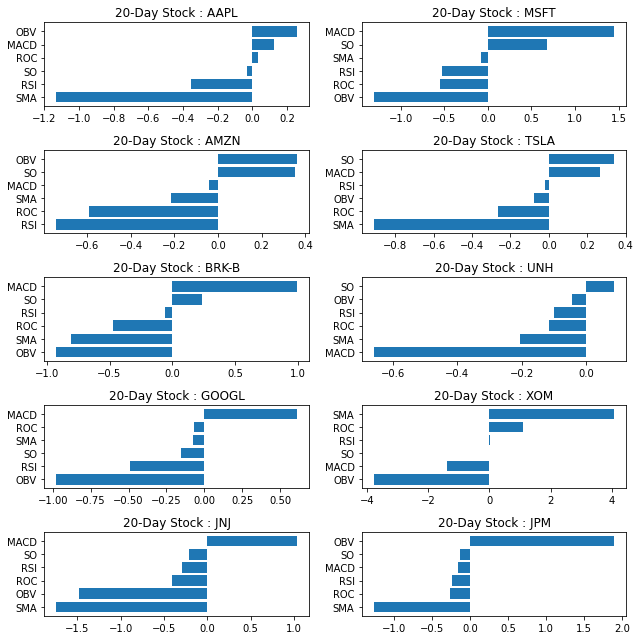

In [ ]:
# Features importance for each stock
fig, axs = plt.subplots( 5, 2, figsize=(9,9))
row =0 
column = 0
for metric in all_metrics_svc['20_day_metrics']:
    title =  "20-Day " + "Stock : " +  metric["symbol"] 
    # Plot Accuracy Score for Each of the features 
    temp_list_values = []
    temp_list_features = []
    # Plot Features Importances 
    for i in metric["sorted_features"]:
        temp_list_values.append(i[1])
        temp_list_features.append(i[0])
    # axs[row, column].barh(features_names , metric["feature_importances"][0])
    axs[row, column].barh(temp_list_features , temp_list_values)
    axs[row, column].title.set_text(title)
    column+=1
    if(column%2==0):
      column=0
      row +=1
plt.tight_layout()

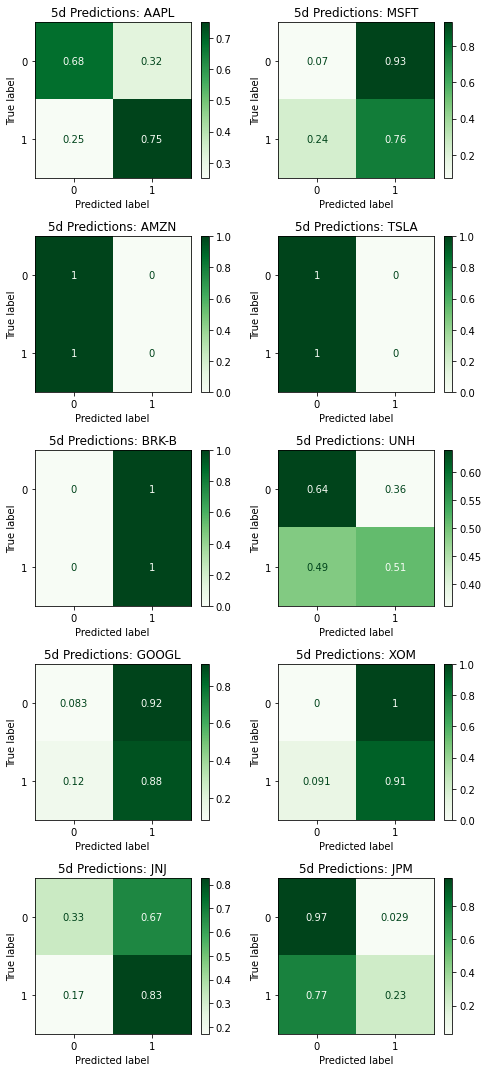

In [ ]:
#Plotting confusion matrix for 5 days 
models_5d_svc = [metrics_5d['best_estimator'] for metrics_5d in all_metrics_svc['5_day_metrics']]
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(7,15))
i = 0
for cls, ax in zip(models_5d_svc, axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_test_5d[i], 
                          y_test_5d[i], 
                          ax=ax, 
                          normalize='true',
                          cmap='Greens')
    ax.title.set_text("5d Predictions: " + tickers[i])
    i += 1
plt.tight_layout()  
plt.show()

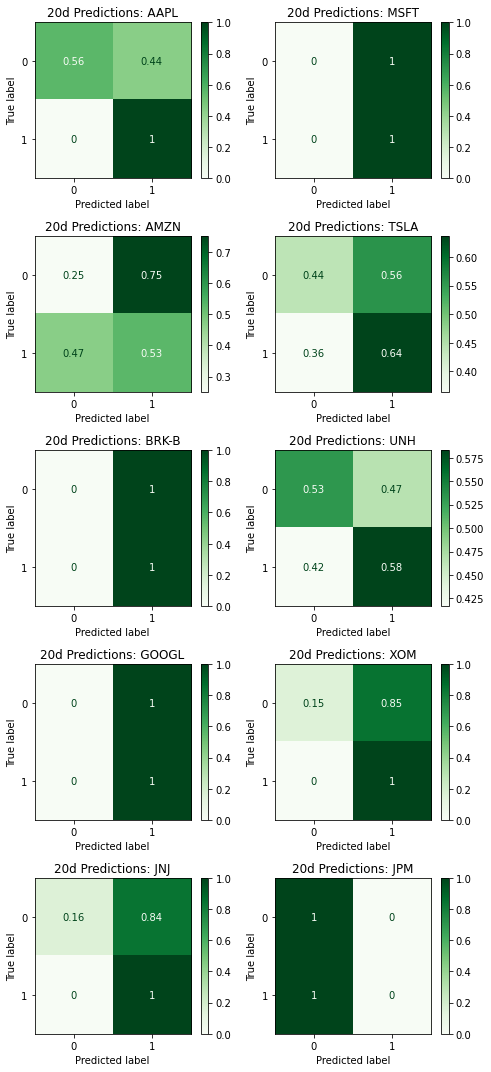

In [ ]:
models_20d_svc = [metrics_20d['best_estimator'] for metrics_20d in all_metrics_svc['20_day_metrics']]
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(7,15))
i = 0
for cls, ax in zip(models_20d_svc, axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_test_20d[i], 
                          y_test_20d[i], 
                          ax=ax, 
                          normalize='true',
                          cmap='Greens')

    ax.title.set_text("20d Predictions: " + tickers[i])
    i += 1
plt.tight_layout()  
plt.show()

###Random Forest (Dominic Insogna dmi2116)

In [ ]:

models_random_forest_5d = []
models_random_forest_20d = []
scores_5d = []
scores_20d = []

#5 day predictions
for i, stock in enumerate(stocks):
    X_train = X_train_5d[i]
    y_train = y_train_5d[i]
    X_test = X_test_5d[i]
    y_test = y_test_5d[i]
    
    # Create a Random Forest Classifier
    # rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 42)
    rand_frst_clf = RandomForestClassifier(random_state=42)
    param_grid = {'n_estimators': [100, 200, 500], 'max_depth': [3,5,8], 'max_features': [4, 8]}
    CV = GridSearchCV(estimator=rand_frst_clf, param_grid=param_grid, cv= 5, n_jobs=-1, verbose=2)
    # CV = RandomizedSearchCV(estimator=rand_frst_clf, param_grid=param_grid, cv= 5,verbose=2)
    CV.fit(X_train, y_train)
    # rand_frst_clf_best = RandomForestClassifier(n_estimators=CV.best_params_['n_estimators'],max_depth=CV.best_params_['max_depth'], max_features=CV.best_params_['n_estimators'], random_state=42)
    rf_best = CV.best_estimator_

    # Fit the data to the model
    # rand_frst_clf.fit(X_train, y_train)
    # rand_frst_clf_best.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_best.predict(X_test)
    # y_pred = rand_frst_clf_best.predict(X_test)
    
    # Print the Accuracy of our Model.
    score = accuracy_score(y_test, y_pred, normalize = True) * 100.0
    scores_5d.append(score)
    print('5d Random Forest Accuracy (%) for', tickers[i],":", score)
    # print('Accuracy (%): ', accuracy_score(y_test, rand_frst_clf_best.predict(X_test), normalize = True) * 100.0)

    #save models
    models_random_forest_5d.append(rf_best)

#20 day predictions [TBD]
#5 day predictions
for i, stock in enumerate(stocks):
    X_train = X_train_20d[i]
    y_train = y_train_20d[i]
    X_test = X_test_20d[i]
    y_test = y_test_20d[i]
    
    # Create a Random Forest Classifier
    # rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 42)
    rand_frst_clf = RandomForestClassifier(random_state=42)
    param_grid = {'n_estimators': [100, 200, 500], 'max_depth': [3,5,8], 'max_features': [4, 8]}
    CV = GridSearchCV(estimator=rand_frst_clf, param_grid=param_grid, cv= 5, n_jobs=-1, verbose=2)
    # CV = RandomizedSearchCV(estimator=rand_frst_clf, param_grid=param_grid, cv= 5,verbose=2)
    CV.fit(X_train, y_train)
    # rand_frst_clf_best = RandomForestClassifier(n_estimators=CV.best_params_['n_estimators'],max_depth=CV.best_params_['max_depth'], max_features=CV.best_params_['n_estimators'], random_state=42)
    rf_best = CV.best_estimator_

    # Fit the data to the model
    # rand_frst_clf.fit(X_train, y_train)
    # rand_frst_clf_best.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_best.predict(X_test)
    # y_pred = rand_frst_clf_best.predict(X_test)
    
    # Print the Accuracy of our Model.
    score = accuracy_score(y_test, y_pred, normalize = True) * 100.0
    scores_20d.append(score)
    print('20d Random Forest Accuracy (%) for', tickers[i],":", score)

    # print('Accuracy (%): ', accuracy_score(y_test, rand_frst_clf_best.predict(X_test), normalize = True) * 100.0)

    #save models
    models_random_forest_20d.append(rf_best)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
5d Random Forest Accuracy (%) for AAPL : 81.48148148148148
Fitting 5 folds for each of 18 candidates, totalling 90 fits
5d Random Forest Accuracy (%) for MSFT : 43.20987654320987
Fitting 5 folds for each of 18 candidates, totalling 90 fits
5d Random Forest Accuracy (%) for AMZN : 55.55555555555556
Fitting 5 folds for each of 18 candidates, totalling 90 fits
5d Random Forest Accuracy (%) for TSLA : 59.25925925925925
Fitting 5 folds for each of 18 candidates, totalling 90 fits
5d Random Forest Accuracy (%) for BRK-B : 62.96296296296296
Fitting 5 folds for each of 18 candidates, totalling 90 fits
5d Random Forest Accuracy (%) for UNH : 45.67901234567901
Fitting 5 folds for each of 18 candidates, totalling 90 fits
5d Random Forest Accuracy (%) for GOOGL : 40.74074074074074
Fitting 5 folds for each of 18 candidates, totalling 90 fits
5d Random Forest Accuracy (%) for XOM : 48.148148148148145
Fitting 5 folds for each of 18 candidat

In [ ]:
for i in range(len(tickers)):
  y_pred = models_random_forest_5d[i].predict(X_test_5d[i])
  print("5d Classification Report for", tickers[i])
  report = classification_report(y_true = y_test_5d[i], y_pred = y_pred, target_names = ['down','up'], output_dict = True)
  report_df = pd.DataFrame(report).transpose()
  print(report_df)
  print()

5d Classification Report for AAPL
              precision    recall  f1-score    support
down           0.882353  0.731707  0.800000  41.000000
up             0.765957  0.900000  0.827586  40.000000
accuracy       0.814815  0.814815  0.814815   0.814815
macro avg      0.824155  0.815854  0.813793  81.000000
weighted avg   0.824874  0.814815  0.813623  81.000000

5d Classification Report for MSFT
              precision    recall  f1-score    support
down           0.285714  0.046512  0.080000  43.000000
up             0.445946  0.868421  0.589286  38.000000
accuracy       0.432099  0.432099  0.432099   0.432099
macro avg      0.365830  0.457466  0.334643  81.000000
weighted avg   0.360885  0.432099  0.318924  81.000000

5d Classification Report for AMZN
              precision    recall  f1-score    support
down           0.586957  0.613636  0.600000  44.000000
up             0.514286  0.486486  0.500000  37.000000
accuracy       0.555556  0.555556  0.555556   0.555556
macro avg      0

In [ ]:
for i in range(len(tickers)):
  y_pred = models_random_forest_20d[i].predict(X_test_20d[i])
  print("20d Classification Report for", tickers[i])
  report = classification_report(y_true = y_test_20d[i], y_pred = y_pred, target_names = ['down','up'], output_dict = True)
  report_df = pd.DataFrame(report).transpose()
  print(report_df)
  print()

20d Classification Report for AAPL
              precision    recall  f1-score    support
down           0.937500  0.600000  0.731707  50.000000
up             0.591837  0.935484  0.725000  31.000000
accuracy       0.728395  0.728395  0.728395   0.728395
macro avg      0.764668  0.767742  0.728354  81.000000
weighted avg   0.805209  0.728395  0.729140  81.000000

20d Classification Report for MSFT
              precision    recall  f1-score    support
down           0.666667  0.156863  0.253968  51.000000
up             0.376812  0.866667  0.525253  30.000000
accuracy       0.419753  0.419753  0.419753   0.419753
macro avg      0.521739  0.511765  0.389610  81.000000
weighted avg   0.559313  0.419753  0.354444  81.000000

20d Classification Report for AMZN
              precision    recall  f1-score    support
down           0.741935  0.359375  0.484211  64.000000
up             0.180000  0.529412  0.268657  17.000000
accuracy       0.395062  0.395062  0.395062   0.395062
macro avg    

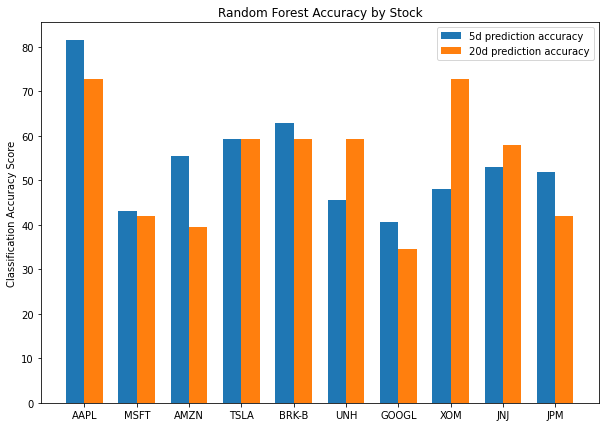

In [ ]:

labels = tickers

x = np.arange(len(labels))
width = 0.35  # the width of the bars
plt.figure(figsize=(10,7))
rects1 = plt.bar(x - width/2, scores_5d, width, label='5d prediction accuracy')
rects2 = plt.bar(x + width/2, scores_20d, width, label='20d prediction accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('Classification Accuracy Score')
plt.title('Random Forest Accuracy by Stock')
plt.xticks(x, labels)
plt.legend()

plt.show()

In [ ]:
print("Mean Random Forest Accuracy for 5d Predictions:", np.mean(scores_5d))
print("Mean Random Forest Accuracy for 20d Predictions:", np.mean(scores_20d))

Mean Random Forest Accuracy for 5d Predictions: 54.19753086419753
Mean Random Forest Accuracy for 20d Predictions: 53.95061728395061


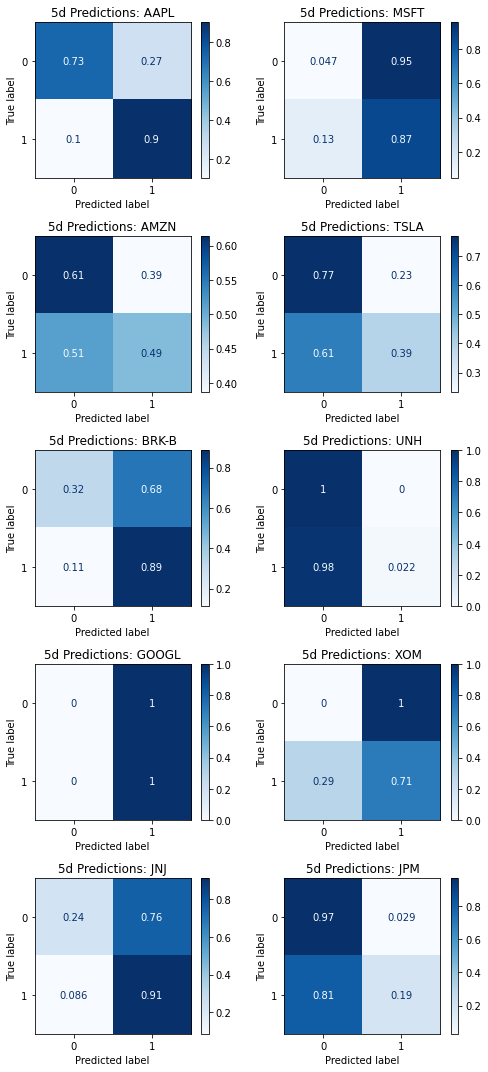

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(7,15))
i = 0
for cls, ax in zip(models_random_forest_5d, axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_test_5d[i], 
                          y_test_5d[i], 
                          ax=ax, 
                          normalize='true',
                          cmap='Blues')
                        #  display_labels=data.target_names)
    ax.title.set_text("5d Predictions: " + tickers[i])
    i += 1
plt.tight_layout()  
plt.show()

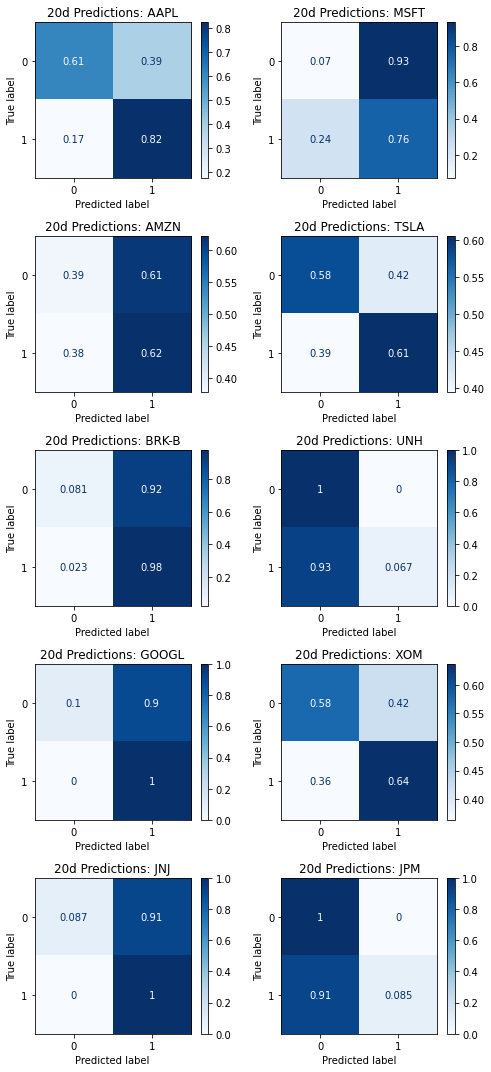

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(7,15))
i = 0
for cls, ax in zip(models_random_forest_20d, axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_test_5d[i], 
                          y_test_5d[i], 
                          ax=ax, 
                          normalize='true',
                          cmap='Blues')
                        #  display_labels=data.target_names)
    ax.title.set_text("20d Predictions: " + tickers[i])
    i += 1
plt.tight_layout()  
plt.show()

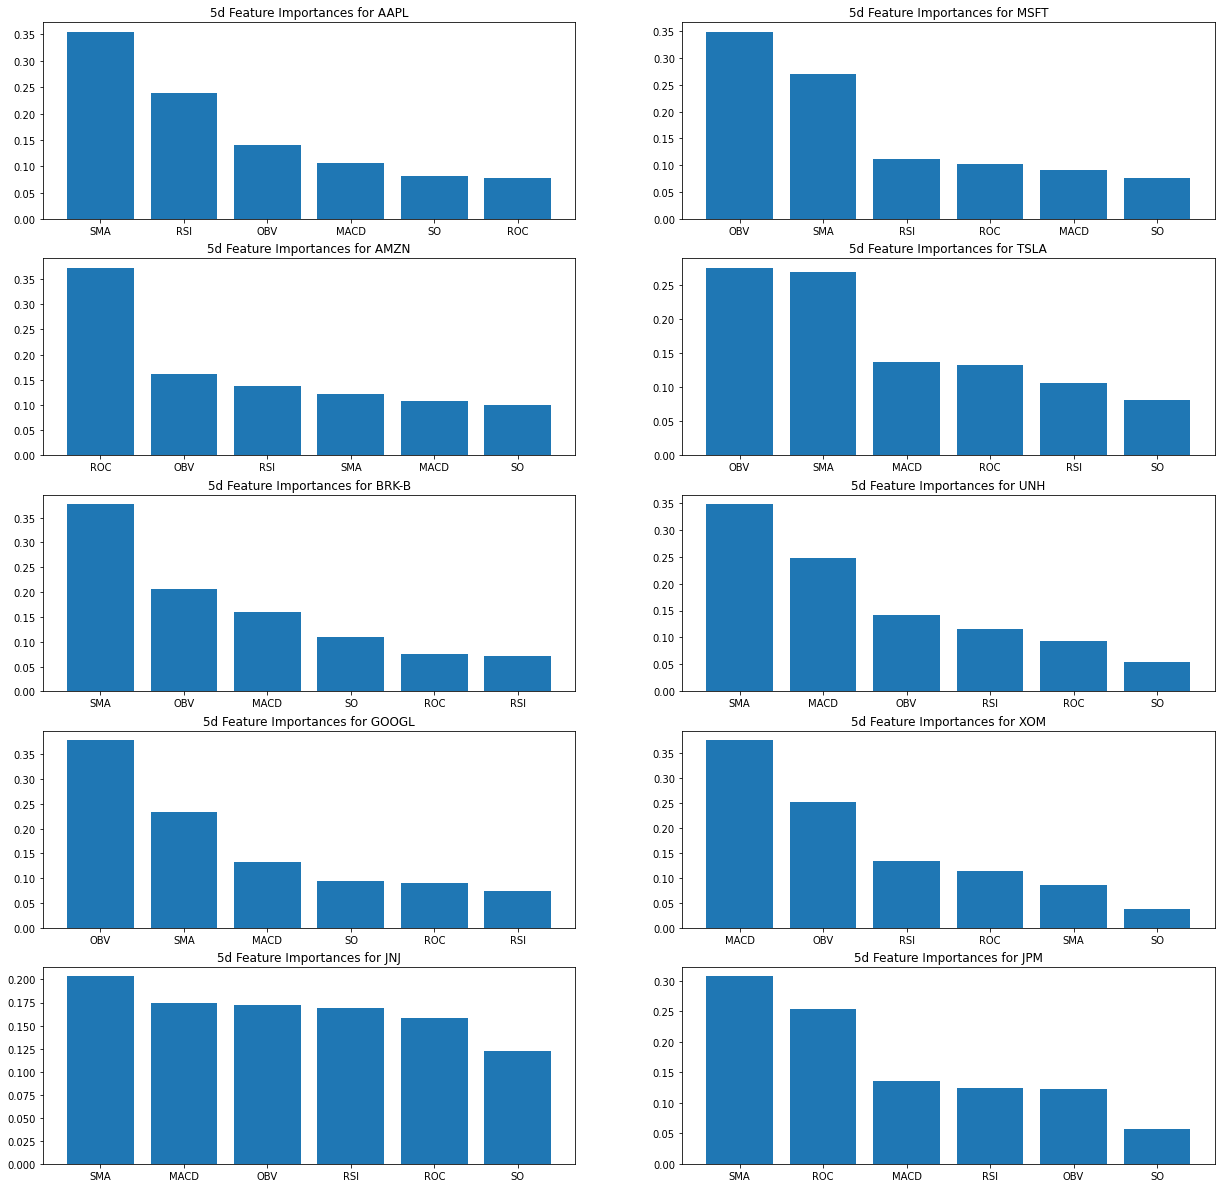

In [ ]:
#5d Feature importances
fig, axs = plt.subplots( 5, 2, figsize=(21,21))
idx = 0
for i in range(5):
  for j in range(2):
    importances = models_random_forest_5d[idx].feature_importances_
    sorted_index = np.argsort(importances)[::-1]
    x_values = range(len(importances))
    labels = np.array(feature_names)[sorted_index]
    axs[i][j].bar(x_values, importances[sorted_index], tick_label=labels)
    # axs[i][j].set_xticks(rotation=90)
    axs[i][j].set_title(f"5d Feature Importances for {tickers[idx]}")
    idx += 1
plt.show()

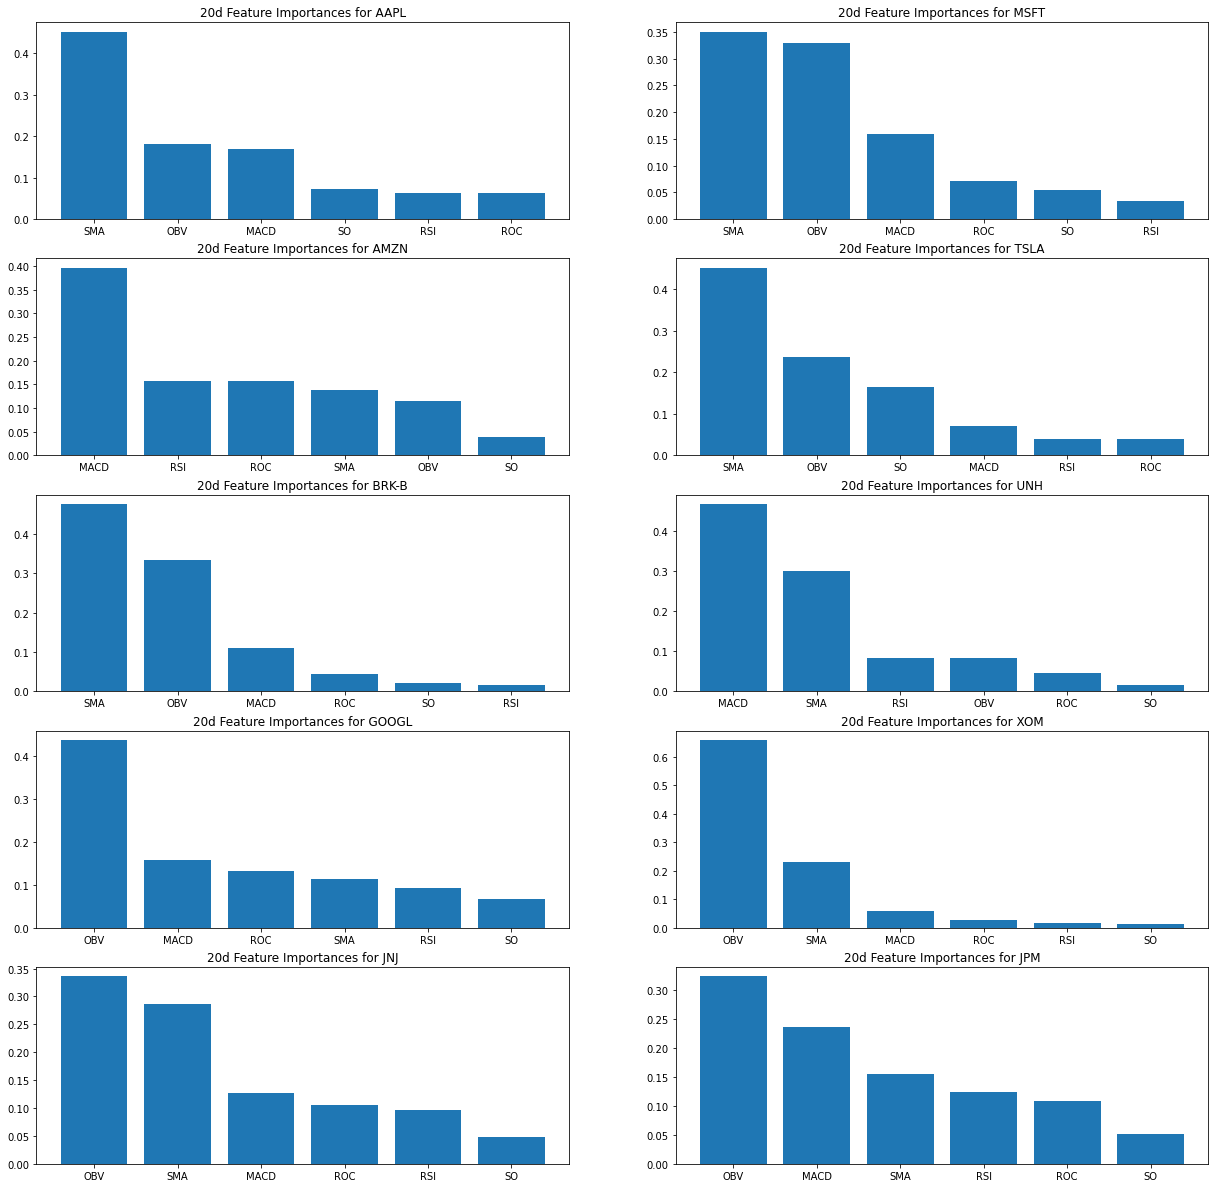

In [ ]:
#20d Feature importances
fig, axs = plt.subplots( 5, 2, figsize=(21,21))
idx = 0
for i in range(5):
  for j in range(2):
    importances = models_random_forest_20d[idx].feature_importances_
    sorted_index = np.argsort(importances)[::-1]
    x_values = range(len(importances))
    labels = np.array(feature_names)[sorted_index]
    axs[i][j].bar(x_values, importances[sorted_index], tick_label=labels)
    # axs[i][j].set_xticks(rotation=90)
    axs[i][j].set_title(f"20d Feature Importances for {tickers[idx]}")
    idx += 1
plt.show()

### XGBoost (Ruoyu Chen rc3506) 

---



In [ ]:
scores_xgboost_5d=[]
scores_xgboost_20d=[]
models_xgb_5d=[]
models_xgb_20d=[]

#5 day predictions
for i, stock in enumerate(stocks):
    # select train and test dataset
    X_train=X_train_5d[i]
    y_train=y_train_5d[i]
    X_test=X_test_5d[i]
    y_test=y_test_5d[i]
    
    #select best parameters
    X = stock[feature_names]
    y_5d = stock['5d_label']
    param_grid = {'n_estimators': range(100,600,100), 'max_depth': range(3,8,1), 'learning_rate':np.linspace(0.01,0.1,5)}
    model=RandomizedSearchCV(XGBClassifier(random_state=42),param_grid,cv =10)
    model.fit(X,y_5d)
    
    #train model with best parameters
    xgb_best=XGBClassifier(n_estimators=model.best_params_['n_estimators'],max_depth=model.best_params_['max_depth'], learning_rate=model.best_params_['learning_rate'], random_state=42)
    xgb_best.fit(X_train, y_train)
    
    # Model accuracy
    xgbscore=xgb_best.score(X_test,y_test)
    scores_xgboost_5d.append(round(xgbscore,4))
    print("5 day predictions for ",tickers[i],'is ',round(xgbscore,4))
    
    #save models
    models_xgb_5d.append(xgb_best)



#20 day predictions
for i, stock in enumerate(stocks):
    # select train and test dataset
    X_train=X_train_20d[i]
    y_train=y_train_20d[i]
    X_test=X_test_20d[i]
    y_test=y_test_20d[i]
    
    #select best parameters
    X = stock[feature_names]
    y_20d = stock['20d_label']
    param_grid = {'n_estimators': range(100,600,100), 'max_depth': range(3,8,1), 'learning_rate':np.linspace(0.01,0.1,5)}
    model=RandomizedSearchCV(XGBClassifier(random_state=42),param_grid,cv =10)
    model.fit(X,y_20d)
    
    #train model with best parameters
    xgb_best=XGBClassifier(n_estimators=model.best_params_['n_estimators'],max_depth=model.best_params_['max_depth'], learning_rate=model.best_params_['learning_rate'], random_state=42)
    xgb_best.fit(X_train, y_train)
    
    # Model accuracy
    xgbscore=xgb_best.score(X_test,y_test)
    scores_xgboost_20d.append(round(xgbscore,4))
    print("20 day predictions for ",tickers[i],'is ',round(xgbscore,4))
    
    #save models
    models_xgb_20d.append(xgb_best)


5 day predictions for  AAPL is  0.679
5 day predictions for  MSFT is  0.3086
5 day predictions for  AMZN is  0.5062
5 day predictions for  TSLA is  0.5556
5 day predictions for  BRK-B is  0.5926
5 day predictions for  UNH is  0.5185
5 day predictions for  GOOGL is  0.4074
5 day predictions for  XOM is  0.4074
5 day predictions for  JNJ is  0.5309
5 day predictions for  JPM is  0.4938
20 day predictions for  AAPL is  0.7407
20 day predictions for  MSFT is  0.3827
20 day predictions for  AMZN is  0.5556
20 day predictions for  TSLA is  0.7531
20 day predictions for  BRK-B is  0.5679
20 day predictions for  UNH is  0.642
20 day predictions for  GOOGL is  0.5062
20 day predictions for  XOM is  0.6173
20 day predictions for  JNJ is  0.6296
20 day predictions for  JPM is  0.4198


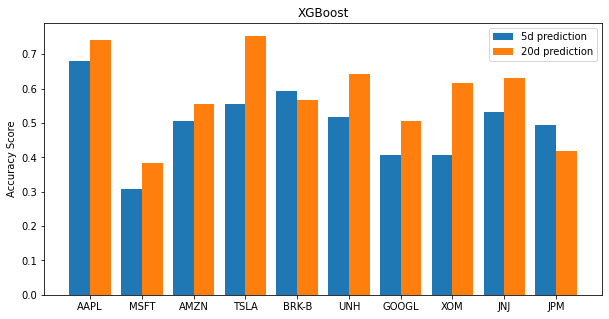

In [ ]:
labels = tickers
x = np.arange(len(labels))  
width = 0.4 
plt.figure(figsize=(10,5))
plt.bar(x - width/2, scores_xgboost_5d, width, label='5d prediction')
plt.bar(x + width/2, scores_xgboost_20d, width, label='20d prediction')
plt.ylabel('Accuracy Score')
plt.title('XGBoost')
plt.xticks(x, labels)
plt.legend()
plt.show()

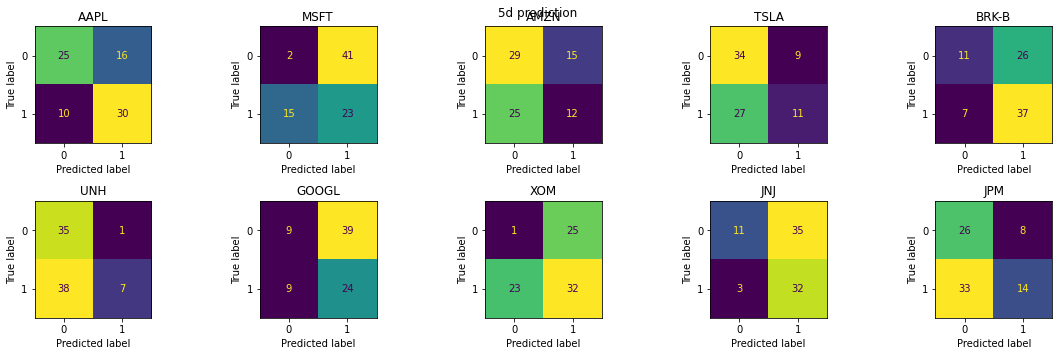

In [ ]:
#condusion matrix for 5 days
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,5))
i = 0
for xgb, ax in zip(models_xgb_5d, axes.flatten()):
    plot_confusion_matrix(xgb,X_test_5d[i],y_test_5d[i], ax=ax,colorbar=False)
    ax.title.set_text(tickers[i])
    i += 1
plt.suptitle('5d prediction')
plt.tight_layout()  
plt.show()

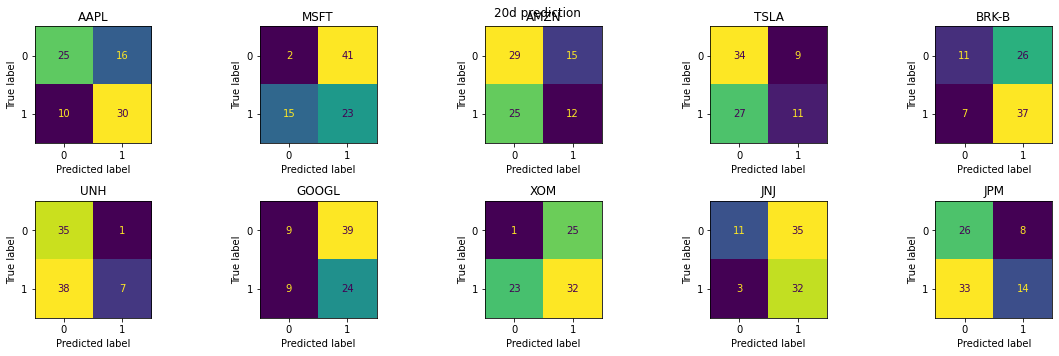

In [ ]:
#condusion matrix for 20 days
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,5))
i = 0
for xgb, ax in zip(models_xgb_5d, axes.flatten()):
    plot_confusion_matrix(xgb,X_test_5d[i],y_test_5d[i], ax=ax,colorbar=False)
    ax.title.set_text(tickers[i])
    i += 1
plt.suptitle('20d prediction')
plt.tight_layout()  
plt.show()

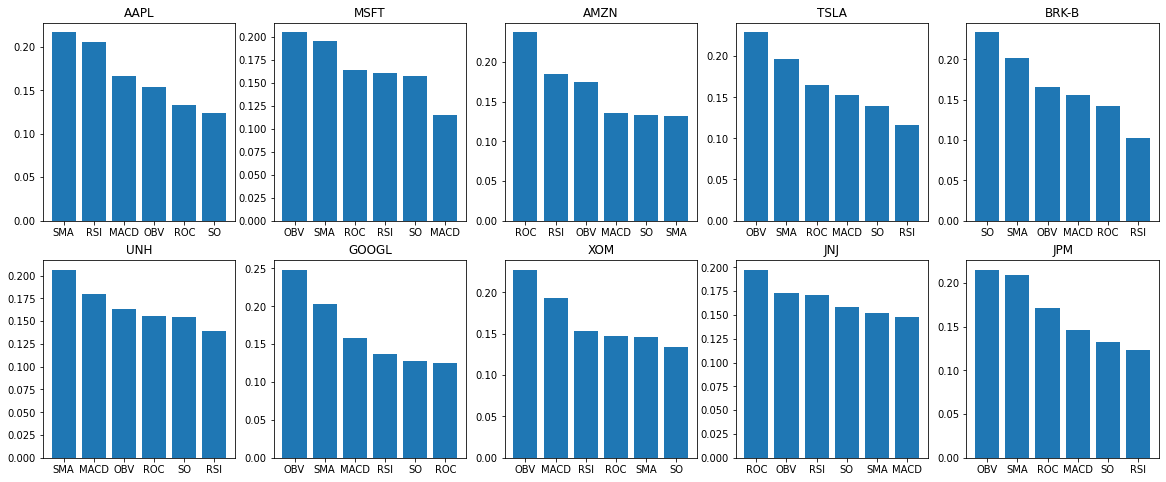

In [ ]:
#5d Feature importances
fig, axs = plt.subplots( 2, 5, figsize=(20,8))
idx = 0
for i in range(2):
  for j in range(5):
    importances = models_xgb_5d[idx].feature_importances_
    sorted_index = np.argsort(importances)[::-1]
    x_values = range(len(importances))
    labels = np.array(feature_names)[sorted_index]
    axs[i][j].bar(x_values, importances[sorted_index], tick_label=labels)
    # axs[i][j].set_xticks(rotation=90)
    axs[i][j].set_title(tickers[idx])
    idx += 1
plt.show()

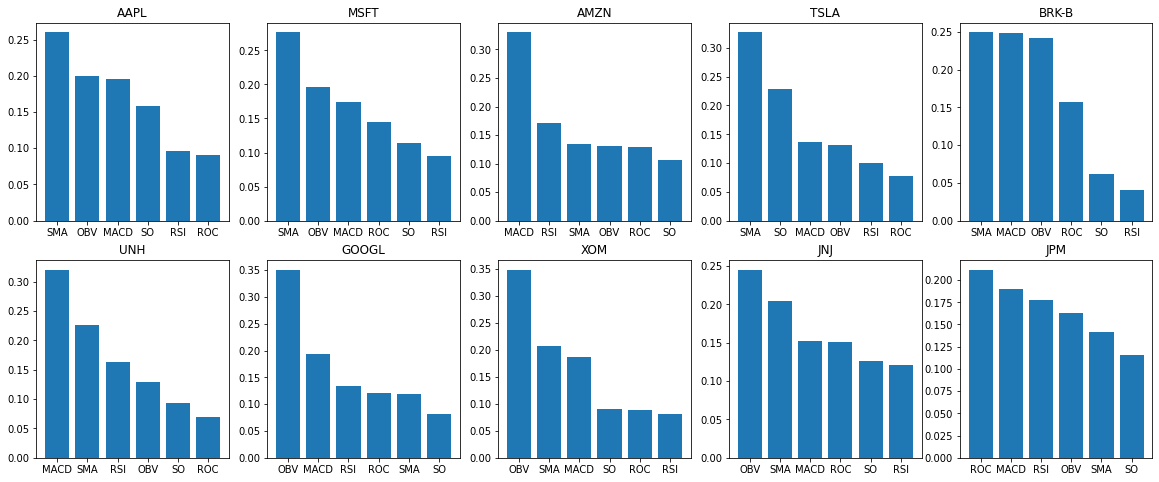

In [ ]:
#20d Feature importances
fig, axs = plt.subplots( 2, 5, figsize=(20,8))
idx = 0
for i in range(2):
  for j in range(5):
    importances = models_xgb_20d[idx].feature_importances_
    sorted_index = np.argsort(importances)[::-1]
    x_values = range(len(importances))
    labels = np.array(feature_names)[sorted_index]
    axs[i][j].bar(x_values, importances[sorted_index], tick_label=labels)
    # axs[i][j].set_xticks(rotation=90)
    axs[i][j].set_title(tickers[idx])
    idx += 1
plt.show()

### Logistic Regression (Turner Mandeville tmm2169)

In [ ]:
print(sns.__version__)

valid_forward_periods = ('5d', '20d')

def data_for_forward_period(forward_period, stock_idx):
    if forward_period not in (valid_forward_periods):
      raise ValueError(f'forward_period can only be one of {valid_forward_periods}')
    if forward_period == '5d':
        X_train = X_train_5d[stock_idx]
        y_train = y_train_5d[stock_idx]
        X_test = X_test_5d[stock_idx]
        y_test = y_test_5d[stock_idx]
    else:
        X_train = X_train_20d[stock_idx]
        y_train = y_train_20d[stock_idx]
        X_test = X_test_20d[stock_idx]
        y_test = y_test_20d[stock_idx]
    return X_train, y_train, X_test, y_test

def lr_generate_vanilla_models(forward_period):
    lr_data_ = []
    lr_models_ = []

    for i, stock in enumerate(tickers):
        X_train, y_train, X_test, y_test = data_for_forward_period(forward_period, i)
        model = Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("logistic", LogisticRegression())
            ]
        )
        model.fit(X_train, y_train)
        
        ytrain_pred = model.predict(X_train)
        ytest_pred = model.predict(X_test)

        lr_models_.append(model)
        lr_data_.append((
            stock,
            'Train',
            accuracy_score(y_train, ytrain_pred),
        ))
        lr_data_.append((
            stock,
            'Test',
            accuracy_score(y_test, ytest_pred)
        ))

    return lr_models_, lr_data_

def lr_generate_plots(forward_period, lr_models_to_plot, lr_data_to_plot):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
    accuracys = pd.DataFrame(lr_data_to_plot, columns=['Stock', 'Dataset', 'Accuracy'])
    sns.barplot(data=accuracys, x="Stock", y="Accuracy", hue="Dataset", ax=ax)
    sns.move_legend(ax, bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.title(f'{forward_period} Accuracy - Vanilla Logistic Regression')
    fig.tight_layout()
    print()

    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,4), sharex=True, sharey=True)
    for stock, model, ax in zip(tickers, lr_models_to_plot, axes.flatten()):
        logistic_regressor = model['logistic']
        sns.barplot(x=logistic_regressor.coef_.flatten(), y=feature_names, ax=ax)
        ax.set_title(stock)

    fig.tight_layout()

    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12,6))
    for stock_idx, (stock, model, ax) in enumerate(zip(tickers, lr_models_to_plot, axes.flatten())):
        _, _, X_test, y_test = data_for_forward_period(forward_period, stock_idx)
        ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, colorbar=False, ax=ax)
        ax.set_title(stock)
    fig.tight_layout()


0.11.2


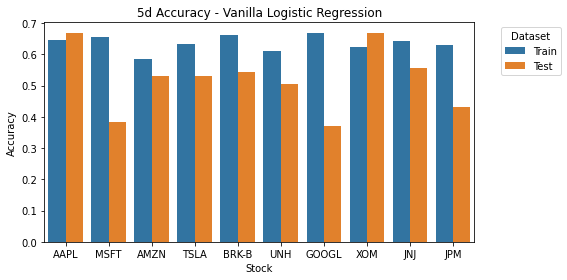

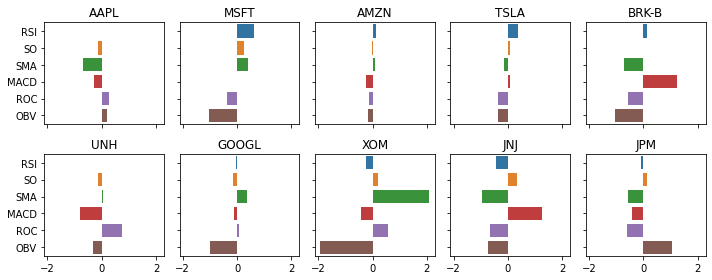

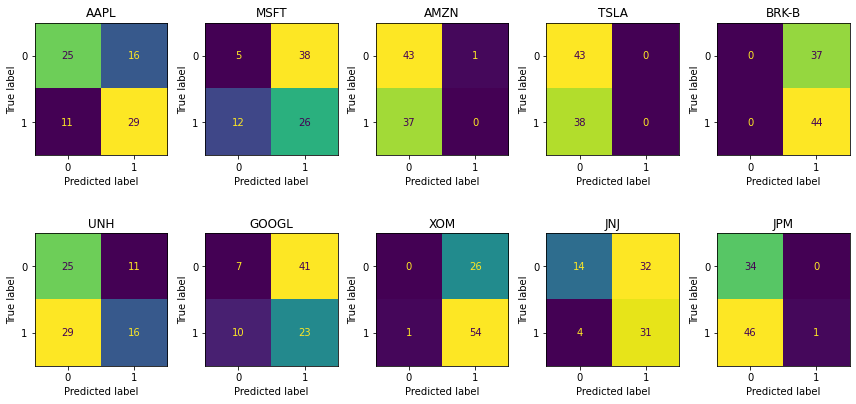

In [ ]:
lr_models_5d, lr_data_5d = lr_generate_vanilla_models('5d')
lr_generate_plots('5d', lr_models_5d, lr_data_5d)

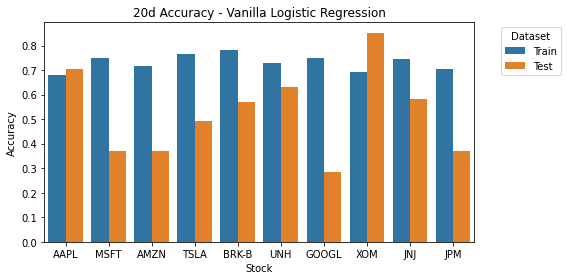

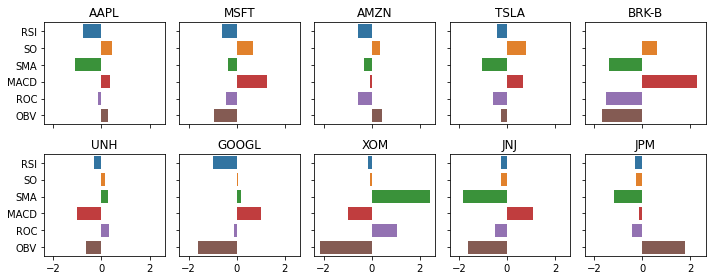

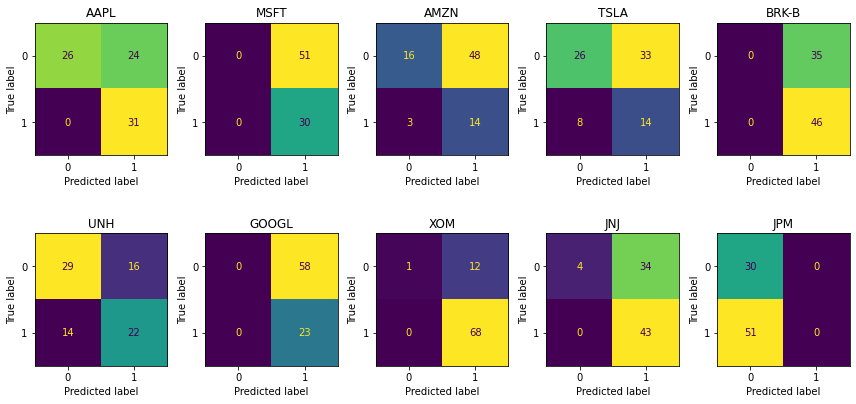

In [ ]:
lr_models_20d, lr_data_20d = lr_generate_vanilla_models('20d')
lr_generate_plots('20d', lr_models_20d, lr_data_20d)

In [ ]:

def lr_generate_cv_models(forward_period):
    lr_gs_data_ = []
    lr_gs_models_ = []
    lr_gs_results_ = []

    ts_cv = TimeSeriesSplit(
        n_splits=5,
        gap=0,
    )

    param_grid = {
        'logistic__penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'logistic__C': np.logspace(-1, 4, 4),
        'logistic__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    }

    for i, stock in enumerate(tickers):
        X_train, y_train, X_test, y_test = data_for_forward_period(forward_period, i)
        pipeline = Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("logistic", LogisticRegression())
            ]
        )

        model = GridSearchCV(pipeline, param_grid, scoring='accuracy', refit=True, cv=ts_cv)
        results = model.fit(X_train, y_train)

        ytrain_pred = model.predict(X_train)
        ytest_pred = model.predict(X_test)
        
        lr_gs_results_.append(results)
        lr_gs_models_.append(model)

        lr_gs_data_.append((
            stock,
            'Train',
            accuracy_score(y_train, ytrain_pred),
        ))
        lr_gs_data_.append((
            stock,
            'Test',
            accuracy_score(y_test, ytest_pred)
        ))

    return lr_gs_models_, lr_gs_data_, lr_gs_results_

def lr_generate_cv_plots(forward_period, lr_gs_models_to_plot, lr_gs_data_to_plot, lr_gs_results_to_plot):
    lr_param_data = []
    for stock, grid_search, result in zip(tickers, lr_gs_models_to_plot, lr_gs_results_to_plot):
        lr_param_data.append((
            stock,
            grid_search.best_score_,
            grid_search.best_params_['logistic__C'],
            grid_search.best_params_['logistic__penalty'],
            grid_search.best_params_['logistic__solver'],
        ))

    param_df = pd.DataFrame(lr_param_data, columns=['Stock', 'BestScore', 'C', 'Penalty', 'Solver'])
    display(param_df)
    print()

    # accuracys
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
    grid_search_accuracys = pd.DataFrame(lr_gs_data_to_plot, columns=['Stock', 'Dataset', 'Accuracy'])
    sns.barplot(data=grid_search_accuracys,
        x="Stock", y="Accuracy", hue="Dataset", ax=ax)
    sns.move_legend(ax, bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.title(f'{forward_period} Accuracy for Best Estimator - GridSearch Tuned Logistic Regression')
    fig.tight_layout()
    print()

    # feature importances
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,4))
    for stock, model, ax in zip(tickers, lr_gs_models_to_plot, axes.flatten()):
        pipeline = model.best_estimator_
        logistic_regressor = pipeline['logistic']
        sns.barplot(x=logistic_regressor.coef_.flatten(), y=feature_names, ax=ax)
        ax.set_title(stock)
    fig.tight_layout()

    # confusion matrices
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12,6))
    for stock_idx, (stock, model, ax) in enumerate(zip(tickers, lr_gs_models_to_plot, axes.flatten())):
        _, _, X_test, y_test = data_for_forward_period(forward_period, stock_idx)
        ConfusionMatrixDisplay.from_estimator(model.best_estimator_, X_test, y_test, colorbar=False, ax=ax)
        ax.set_title(stock)
    fig.tight_layout()



,Stock,BestScore,C,Penalty,Solver
0,AAPL,0.467925,0.100000,l1,liblinear
1,MSFT,0.471698,0.100000,l1,saga
2,AMZN,0.520755,4.641589,l1,liblinear
3,TSLA,0.437736,0.100000,l1,liblinear
4,BRK-B,0.558491,215.443469,l1,liblinear
5,UNH,0.539623,4.641589,l1,saga
6,GOOGL,0.550943,0.100000,l1,saga
7,XOM,0.562264,0.100000,l1,liblinear
8,JNJ,0.543396,0.100000,none,saga
9,JPM,0.562264,0.100000,l1,saga


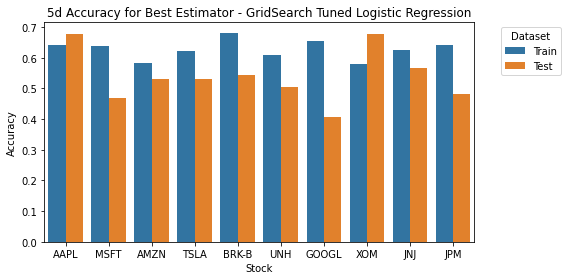

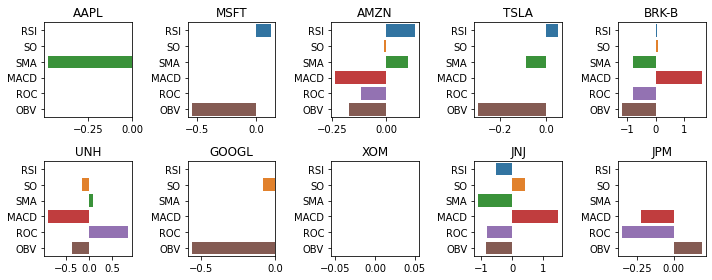

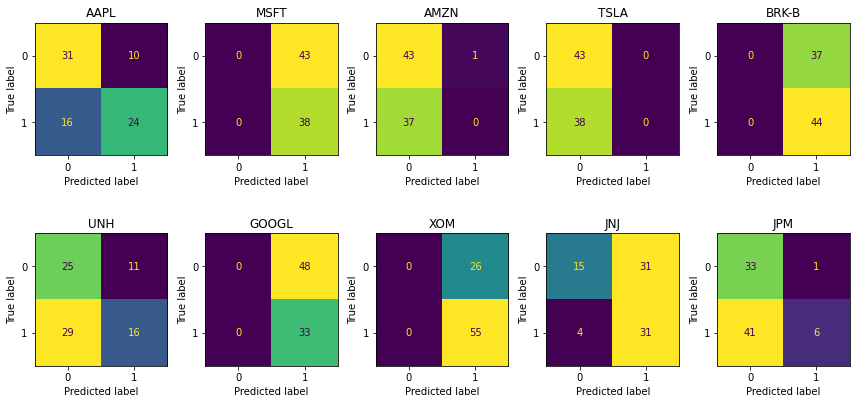

In [ ]:
lr_cv_models_5d, lr_cv_data_5d, lr_cv_results_5d = lr_generate_cv_models('5d')
lr_generate_cv_plots('5d', lr_cv_models_5d, lr_cv_data_5d, lr_cv_results_5d)


,Stock,BestScore,C,Penalty,Solver
0,AAPL,0.460377,0.100000,l2,newton-cg
1,MSFT,0.505660,0.100000,none,newton-cg
2,AMZN,0.611321,0.100000,l2,liblinear
3,TSLA,0.475472,0.100000,l1,liblinear
4,BRK-B,0.569811,10000.000000,l1,liblinear
5,UNH,0.694340,4.641589,l2,newton-cg
6,GOOGL,0.596226,0.100000,none,newton-cg
7,XOM,0.516981,4.641589,l2,liblinear
8,JNJ,0.584906,0.100000,l1,liblinear
9,JPM,0.490566,4.641589,l2,newton-cg


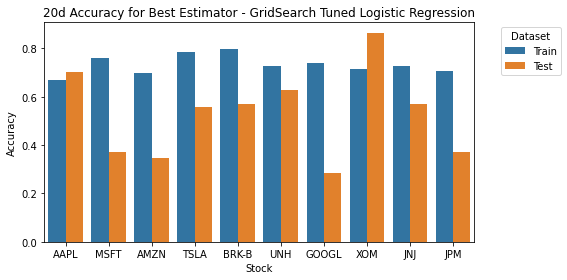

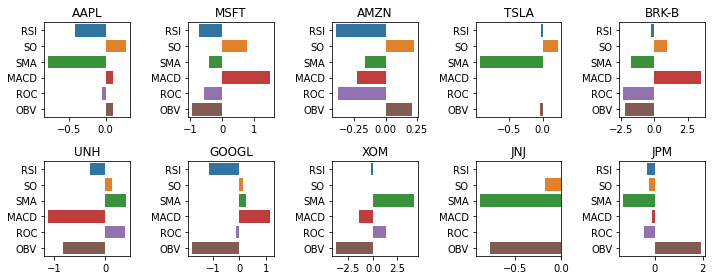

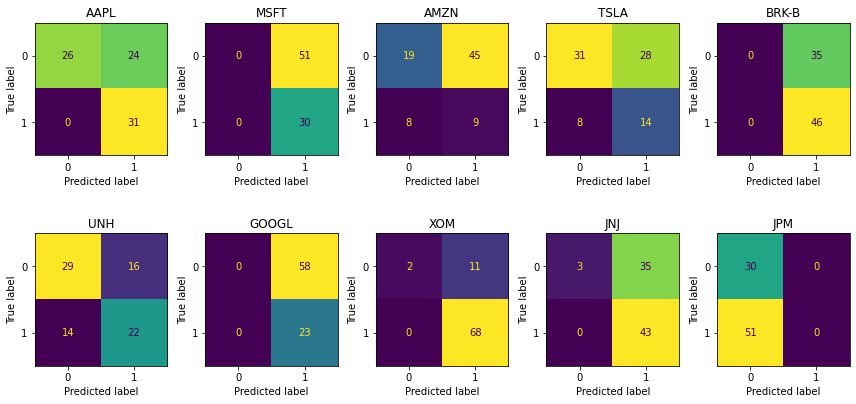

In [ ]:
lr_cv_models_20d, lr_cv_data_20d, lr_cv_results_20d = lr_generate_cv_models('20d')
lr_generate_cv_plots('20d', lr_cv_models_20d, lr_cv_data_20d, lr_cv_results_20d)


###LSTM (Yan Gong yg2818)

---



In [ ]:
# Plot function
def plot(history):
    # Plot train vs validation loss over each epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epoch = range(len(loss))
    
    _ = plt.figure()
    plt.title('Train and validation loss over each epoch')
    plt.plot(epoch, loss, color = 'blue', label = 'Train')
    plt.plot(epoch, val_loss, color = 'red', label = 'Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           42800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 125,751
Trainable params: 125,751
Non-trainable params: 0
_________________________________________________________________
(260, 60, 6) (260,)
(21, 60, 6) (21,)
Epoch 1/5
260/260 [==============================] - 13s 39ms/step - loss: 0.3249 - val_loss: 0.2345
Epoch 2/5
260/260 [========================

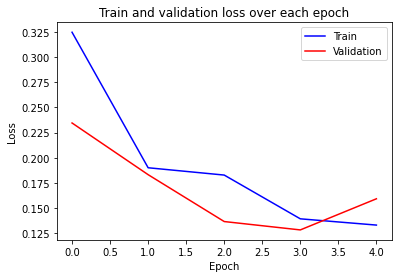

1/1 [==============================] - 1s 962ms/step
R2 score: 0.5218742487616206
Buying the stock is suggested. 
(260, 60, 6) (260,)
(21, 60, 6) (21,)
Epoch 1/5
260/260 [==============================] - 14s 41ms/step - loss: 0.1299 - val_loss: 0.1696
Epoch 2/5
260/260 [==============================] - 9s 36ms/step - loss: 0.1185 - val_loss: 0.1642
Epoch 3/5
260/260 [==============================] - 9s 35ms/step - loss: 0.1121 - val_loss: 0.4427
Epoch 4/5
260/260 [==============================] - 9s 36ms/step - loss: 0.1098 - val_loss: 0.2491
Epoch 5/5
260/260 [==============================] - 9s 36ms/step - loss: 0.1002 - val_loss: 0.3608


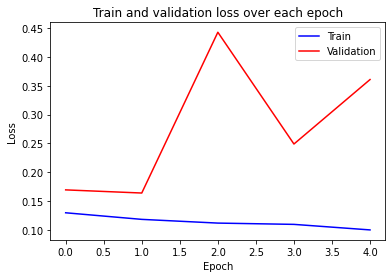

1/1 [==============================] - 1s 1s/step
R2 score: -0.5675870505152572
Buying the stock is suggested. 
(260, 60, 6) (260,)
(21, 60, 6) (21,)
Epoch 1/5
260/260 [==============================] - 13s 39ms/step - loss: 0.1388 - val_loss: 0.1780
Epoch 2/5
260/260 [==============================] - 9s 36ms/step - loss: 0.1224 - val_loss: 0.1436
Epoch 3/5
260/260 [==============================] - 9s 36ms/step - loss: 0.1188 - val_loss: 0.1843
Epoch 4/5
260/260 [==============================] - 9s 36ms/step - loss: 0.1180 - val_loss: 0.1291
Epoch 5/5
260/260 [==============================] - 9s 36ms/step - loss: 0.1179 - val_loss: 0.1571


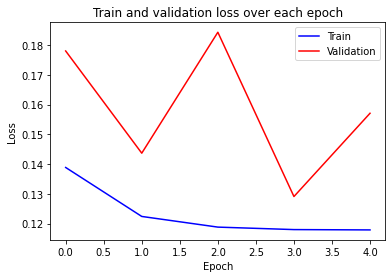

1/1 [==============================] - 1s 823ms/step
R2 score: 0.38476344650206495
Buying the stock is suggested. 
(260, 60, 6) (260,)
(21, 60, 6) (21,)
Epoch 1/5
260/260 [==============================] - 14s 40ms/step - loss: 0.1477 - val_loss: 0.0551
Epoch 2/5
260/260 [==============================] - 9s 36ms/step - loss: 0.1271 - val_loss: 0.2332
Epoch 3/5
260/260 [==============================] - 9s 36ms/step - loss: 0.1256 - val_loss: 0.0891
Epoch 4/5
260/260 [==============================] - 9s 36ms/step - loss: 0.1264 - val_loss: 0.1494
Epoch 5/5
260/260 [==============================] - 10s 40ms/step - loss: 0.1115 - val_loss: 0.1845


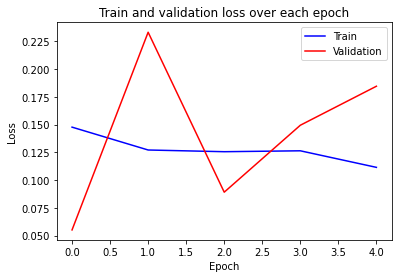

1/1 [==============================] - 1s 972ms/step
R2 score: 0.23528996284325276
Buying the stock is suggested. 
(260, 60, 6) (260,)
(21, 60, 6) (21,)
Epoch 1/5
260/260 [==============================] - 13s 39ms/step - loss: 0.1054 - val_loss: 0.1201
Epoch 2/5
260/260 [==============================] - 11s 41ms/step - loss: 0.1019 - val_loss: 0.1609
Epoch 3/5
260/260 [==============================] - 9s 36ms/step - loss: 0.0858 - val_loss: 0.1851
Epoch 4/5
260/260 [==============================] - 9s 36ms/step - loss: 0.0923 - val_loss: 0.1092
Epoch 5/5
260/260 [==============================] - 9s 36ms/step - loss: 0.0874 - val_loss: 0.1170


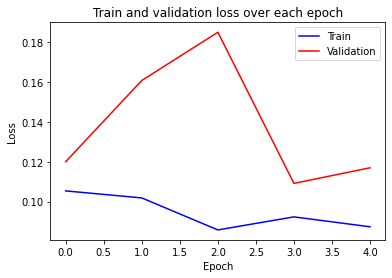

1/1 [==============================] - 1s 817ms/step
R2 score: 0.5678849168836873
Buying the stock is suggested. 
(260, 60, 6) (260,)
(21, 60, 6) (21,)
Epoch 1/5
260/260 [==============================] - 13s 39ms/step - loss: 0.1602 - val_loss: 0.2049
Epoch 2/5
260/260 [==============================] - 9s 36ms/step - loss: 0.1559 - val_loss: 0.1500
Epoch 3/5
260/260 [==============================] - 10s 37ms/step - loss: 0.1391 - val_loss: 0.1581
Epoch 4/5
260/260 [==============================] - 10s 37ms/step - loss: 0.1329 - val_loss: 0.1488
Epoch 5/5
260/260 [==============================] - 9s 36ms/step - loss: 0.1336 - val_loss: 0.1873


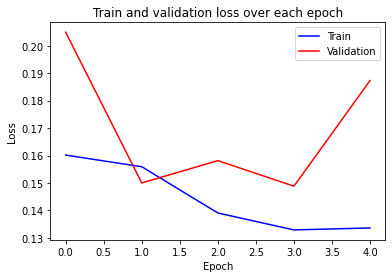

1/1 [==============================] - 1s 859ms/step
R2 score: 0.694569102802336
Selling the stock is suggested. 
(260, 60, 6) (260,)
(21, 60, 6) (21,)
Epoch 1/5
260/260 [==============================] - 13s 40ms/step - loss: 0.1443 - val_loss: 0.3438
Epoch 2/5
260/260 [==============================] - 9s 36ms/step - loss: 0.1288 - val_loss: 0.2969
Epoch 3/5
260/260 [==============================] - 9s 36ms/step - loss: 0.1314 - val_loss: 0.2380
Epoch 4/5
260/260 [==============================] - 9s 36ms/step - loss: 0.1254 - val_loss: 0.2517
Epoch 5/5
260/260 [==============================] - 9s 36ms/step - loss: 0.1259 - val_loss: 0.1988


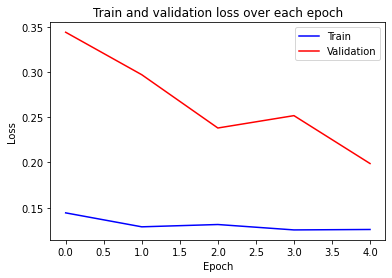

1/1 [==============================] - 1s 901ms/step
R2 score: -0.02278731251365751
Buying the stock is suggested. 
(260, 60, 6) (260,)
(21, 60, 6) (21,)
Epoch 1/5
260/260 [==============================] - 14s 42ms/step - loss: 0.1371 - val_loss: 0.0623
Epoch 2/5
260/260 [==============================] - 9s 36ms/step - loss: 0.1319 - val_loss: 0.0895
Epoch 3/5
260/260 [==============================] - 9s 36ms/step - loss: 0.1242 - val_loss: 0.1273
Epoch 4/5
260/260 [==============================] - 10s 37ms/step - loss: 0.1213 - val_loss: 0.0679
Epoch 5/5
260/260 [==============================] - 9s 36ms/step - loss: 0.1204 - val_loss: 0.1024


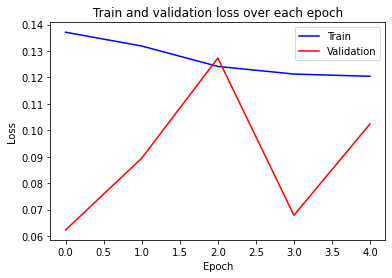

1/1 [==============================] - 1s 826ms/step
R2 score: 0.31485357324661845
Selling the stock is suggested. 
(260, 60, 6) (260,)
(21, 60, 6) (21,)
Epoch 1/5
260/260 [==============================] - 14s 40ms/step - loss: 0.1652 - val_loss: 0.1154
Epoch 2/5
260/260 [==============================] - 11s 42ms/step - loss: 0.1368 - val_loss: 0.1077
Epoch 3/5
260/260 [==============================] - 9s 36ms/step - loss: 0.1410 - val_loss: 0.1315
Epoch 4/5
260/260 [==============================] - 9s 36ms/step - loss: 0.1336 - val_loss: 0.1224
Epoch 5/5
260/260 [==============================] - 10s 37ms/step - loss: 0.1216 - val_loss: 0.1314


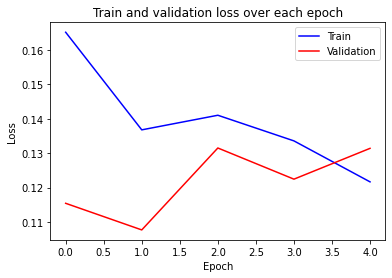

1/1 [==============================] - 1s 834ms/step
R2 score: 0.7653270689012134
Selling the stock is suggested. 
(260, 60, 6) (260,)
(21, 60, 6) (21,)
Epoch 1/5
260/260 [==============================] - 13s 40ms/step - loss: 0.1791 - val_loss: 0.4917
Epoch 2/5
260/260 [==============================] - 10s 37ms/step - loss: 0.1546 - val_loss: 0.3915
Epoch 3/5
260/260 [==============================] - 9s 36ms/step - loss: 0.1559 - val_loss: 0.3119
Epoch 4/5
260/260 [==============================] - 10s 37ms/step - loss: 0.1507 - val_loss: 0.3249
Epoch 5/5
260/260 [==============================] - 10s 37ms/step - loss: 0.1483 - val_loss: 0.2062


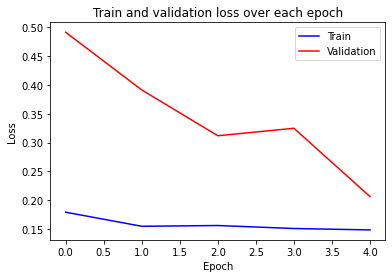

1/1 [==============================] - 1s 886ms/step
R2 score: 0.7774599662637403
Selling the stock is suggested. 
LSTM model scores for the 10 stocks for 5 day predictions: [0.5219, -0.5676, 0.3848, 0.2353, 0.5679, 0.6946, -0.0228, 0.3149, 0.7653, 0.7775]
LSTM model labels for the 10 stocks for 5 day predictions: [1, 1, 1, 1, 1, 0, 1, 0, 0, 0]
(260, 60, 6) (260,)
(21, 60, 6) (21,)
Epoch 1/5
260/260 [==============================] - 14s 40ms/step - loss: 0.1305 - val_loss: 0.1301
Epoch 2/5
260/260 [==============================] - 10s 38ms/step - loss: 0.1200 - val_loss: 0.1264
Epoch 3/5
260/260 [==============================] - 10s 38ms/step - loss: 0.1176 - val_loss: 0.1304
Epoch 4/5
260/260 [==============================] - 10s 37ms/step - loss: 0.1075 - val_loss: 0.1322
Epoch 5/5
260/260 [==============================] - 9s 36ms/step - loss: 0.1142 - val_loss: 0.1449


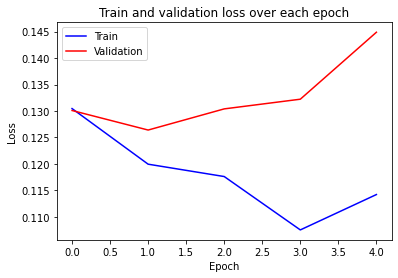

1/1 [==============================] - 1s 859ms/step
R2 score: 0.5646054855559665
Buying the stock is suggested. 
(260, 60, 6) (260,)
(21, 60, 6) (21,)
Epoch 1/5
260/260 [==============================] - 14s 41ms/step - loss: 0.1003 - val_loss: 0.2241
Epoch 2/5
260/260 [==============================] - 10s 37ms/step - loss: 0.0932 - val_loss: 0.3361
Epoch 3/5
260/260 [==============================] - 10s 37ms/step - loss: 0.0867 - val_loss: 0.2281
Epoch 4/5
260/260 [==============================] - 10s 37ms/step - loss: 0.0865 - val_loss: 0.4304
Epoch 5/5
260/260 [==============================] - 10s 37ms/step - loss: 0.0760 - val_loss: 0.4989


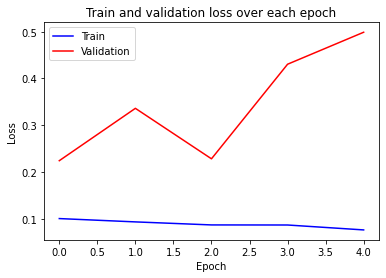

1/1 [==============================] - 1s 833ms/step
R2 score: -1.167583564617157
Buying the stock is suggested. 
(260, 60, 6) (260,)
(21, 60, 6) (21,)
Epoch 1/5
260/260 [==============================] - 14s 40ms/step - loss: 0.1254 - val_loss: 0.1901
Epoch 2/5
260/260 [==============================] - 10s 37ms/step - loss: 0.1050 - val_loss: 0.1591
Epoch 3/5
260/260 [==============================] - 10s 37ms/step - loss: 0.1030 - val_loss: 0.1355
Epoch 4/5
260/260 [==============================] - 11s 42ms/step - loss: 0.1027 - val_loss: 0.1913
Epoch 5/5
260/260 [==============================] - 11s 41ms/step - loss: 0.0988 - val_loss: 0.1779


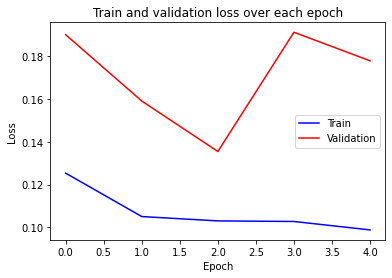

1/1 [==============================] - 1s 866ms/step
R2 score: 0.30305010727678405
Buying the stock is suggested. 
(260, 60, 6) (260,)
(21, 60, 6) (21,)
Epoch 1/5
260/260 [==============================] - 14s 41ms/step - loss: 0.1312 - val_loss: 0.2409
Epoch 2/5
260/260 [==============================] - 10s 37ms/step - loss: 0.1164 - val_loss: 0.0928
Epoch 3/5
260/260 [==============================] - 10s 37ms/step - loss: 0.1048 - val_loss: 0.1558
Epoch 4/5
260/260 [==============================] - 10s 38ms/step - loss: 0.1077 - val_loss: 0.2273
Epoch 5/5
260/260 [==============================] - 10s 37ms/step - loss: 0.1014 - val_loss: 0.1698


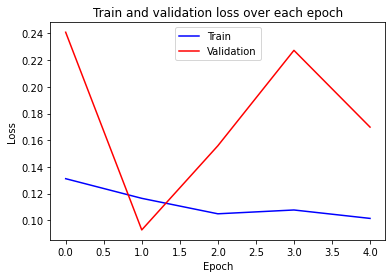

1/1 [==============================] - 1s 844ms/step
R2 score: 0.29628865191540543
Buying the stock is suggested. 
(260, 60, 6) (260,)
(21, 60, 6) (21,)
Epoch 1/5
260/260 [==============================] - 13s 41ms/step - loss: 0.0956 - val_loss: 0.1813
Epoch 2/5
260/260 [==============================] - 10s 37ms/step - loss: 0.0866 - val_loss: 0.1505
Epoch 3/5
260/260 [==============================] - 10s 38ms/step - loss: 0.0844 - val_loss: 0.1892
Epoch 4/5
260/260 [==============================] - 10s 38ms/step - loss: 0.0769 - val_loss: 0.2915
Epoch 5/5
260/260 [==============================] - 10s 37ms/step - loss: 0.0836 - val_loss: 0.1789


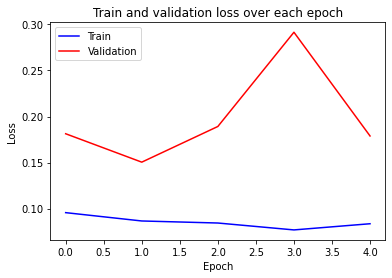

1/1 [==============================] - 1s 852ms/step
R2 score: 0.3394432690670489
Buying the stock is suggested. 
(260, 60, 6) (260,)
(21, 60, 6) (21,)
Epoch 1/5
260/260 [==============================] - 14s 41ms/step - loss: 0.1528 - val_loss: 0.1433
Epoch 2/5
260/260 [==============================] - 10s 37ms/step - loss: 0.1423 - val_loss: 0.1359
Epoch 3/5
260/260 [==============================] - 10s 38ms/step - loss: 0.1313 - val_loss: 0.1489
Epoch 4/5
260/260 [==============================] - 10s 37ms/step - loss: 0.1266 - val_loss: 0.1399
Epoch 5/5
260/260 [==============================] - 10s 38ms/step - loss: 0.1108 - val_loss: 0.1744


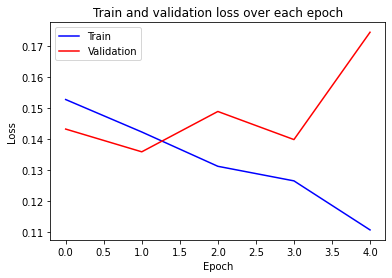

1/1 [==============================] - 1s 849ms/step
R2 score: 0.7155379127541861
Selling the stock is suggested. 
(260, 60, 6) (260,)
(21, 60, 6) (21,)
Epoch 1/5
260/260 [==============================] - 13s 40ms/step - loss: 0.1465 - val_loss: 0.2302
Epoch 2/5
260/260 [==============================] - 10s 37ms/step - loss: 0.1278 - val_loss: 0.2056
Epoch 3/5
260/260 [==============================] - 10s 38ms/step - loss: 0.1220 - val_loss: 0.2070
Epoch 4/5
260/260 [==============================] - 10s 38ms/step - loss: 0.1108 - val_loss: 0.1930
Epoch 5/5
260/260 [==============================] - 10s 38ms/step - loss: 0.1053 - val_loss: 0.2120


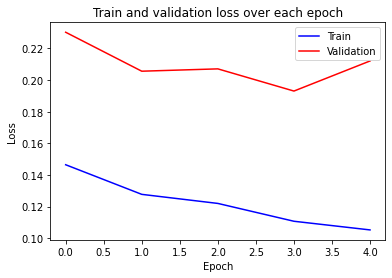

1/1 [==============================] - 1s 853ms/step
R2 score: -0.09104930674214073
Buying the stock is suggested. 
(260, 60, 6) (260,)
(21, 60, 6) (21,)
Epoch 1/5
260/260 [==============================] - 14s 42ms/step - loss: 0.1257 - val_loss: 0.1413
Epoch 2/5
260/260 [==============================] - 10s 39ms/step - loss: 0.1060 - val_loss: 0.0735
Epoch 3/5
260/260 [==============================] - 10s 38ms/step - loss: 0.1043 - val_loss: 0.0855
Epoch 4/5
260/260 [==============================] - 10s 38ms/step - loss: 0.1004 - val_loss: 0.1013
Epoch 5/5
260/260 [==============================] - 10s 38ms/step - loss: 0.0939 - val_loss: 0.0699


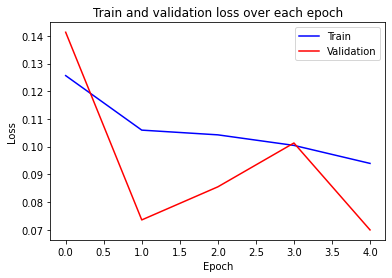

1/1 [==============================] - 1s 871ms/step
R2 score: 0.5323335462465644
Selling the stock is suggested. 
(260, 60, 6) (260,)
(21, 60, 6) (21,)
Epoch 1/5
260/260 [==============================] - 14s 42ms/step - loss: 0.1622 - val_loss: 0.2039
Epoch 2/5
260/260 [==============================] - 10s 38ms/step - loss: 0.1362 - val_loss: 0.1393
Epoch 3/5
260/260 [==============================] - 10s 38ms/step - loss: 0.1195 - val_loss: 0.1116
Epoch 4/5
260/260 [==============================] - 10s 38ms/step - loss: 0.1100 - val_loss: 0.1271
Epoch 5/5
260/260 [==============================] - 10s 38ms/step - loss: 0.1044 - val_loss: 0.1247


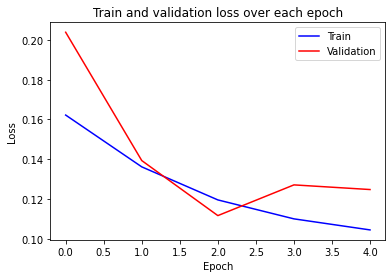

1/1 [==============================] - 1s 851ms/step
R2 score: 0.7772000263888881
Selling the stock is suggested. 
(260, 60, 6) (260,)
(21, 60, 6) (21,)
Epoch 1/5
260/260 [==============================] - 14s 42ms/step - loss: 0.1809 - val_loss: 0.3281
Epoch 2/5
260/260 [==============================] - 10s 38ms/step - loss: 0.1452 - val_loss: 0.2375
Epoch 3/5
260/260 [==============================] - 10s 38ms/step - loss: 0.1384 - val_loss: 0.3431
Epoch 4/5
260/260 [==============================] - 10s 39ms/step - loss: 0.1317 - val_loss: 0.2956
Epoch 5/5
260/260 [==============================] - 10s 39ms/step - loss: 0.1285 - val_loss: 0.1847


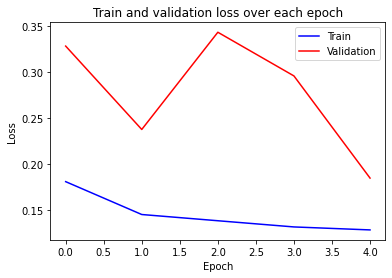

1/1 [==============================] - 1s 1s/step
R2 score: 0.8005877003753371
Selling the stock is suggested. 
LSTM model scores for the 10 stocks for 20 day predictions: [0.5646, -1.1676, 0.3031, 0.2963, 0.3394, 0.7155, -0.091, 0.5323, 0.7772, 0.8006]
LSTM model labels for the 10 stocks for 20 day predictions: [1, 1, 1, 1, 1, 0, 1, 0, 0, 0]


In [ ]:
scores_lstm_5d = []
scores_lstm_20d = []
labels_lstm_5d = []
labels_lstm_20d = []
window = 60

# LSTM model structure
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences = True, input_shape = (window, 6)))
model.add(layers.LSTM(100, return_sequences = False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

# 5 day predictions
for i, stock in enumerate(stocks):
    # Select train and test dataset
    X_train_raw = X_train_5d[i]
    y_train_raw = y_train_5d[i]
    X_test_raw = X_test_5d[i]
    y_test_raw = y_test_5d[i]

    # Create a 60-days window of historical prices
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for i in range(window, X_train_raw.shape[0]):
        X_train.append(X_train_raw[i - window:i])
        y_train.append(X_train_raw[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    print(X_train.shape, y_train.shape)
    for i in range(window, X_test_raw.shape[0]):
        X_test.append(X_test_raw[i - window:i])
        y_test.append(X_test_raw[i, 0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    print(X_test.shape, y_test.shape)
    
    # Train model
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    history = model.fit(X_train, y_train, batch_size = 1, epochs = 5, 
                        validation_data = (X_test, y_test))
    
    # Plot separate plots
    plot(history)
    
    # Model accuracy
    predictions = model.predict(X_test)
    predictions = predictions.reshape((-1, ))
    score = r2_score(y_test, predictions)
    print("R2 score:", score)
    scores_lstm_5d.append(round(score, 4))

    # Label stock
    pred_diff = predictions - y_test
    pred_diff = pred_diff.tolist()
    pred_labels = [1 if x >= 0 else 0 for x in pred_diff]
    if sum(pred_labels) >= len(pred_labels)/2:
        labels_lstm_5d.append(1)
        print("Buying the stock is suggested. ")
    else:
        labels_lstm_5d.append(0)
        print("Selling the stock is suggested. ")
    
    # Save models
    # models_lstm_5d.append(model)

# Print scores and labels for 5 day predictions
print("LSTM model scores for the 10 stocks for 5 day predictions:", scores_lstm_5d)
print("LSTM model labels for the 10 stocks for 5 day predictions:", labels_lstm_5d)


# 20 day predictions
for i, stock in enumerate(stocks):
    # Select train and test dataset
    X_train_raw = X_train_20d[i]
    y_train_raw = y_train_20d[i]
    X_test_raw = X_test_20d[i]
    y_test_raw = y_test_20d[i]
    
    # Create a 60-days window of historical prices
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for i in range(window, X_train_raw.shape[0]):
        X_train.append(X_train_raw[i - window:i])
        y_train.append(X_train_raw[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    print(X_train.shape, y_train.shape)
    for i in range(window, X_test_raw.shape[0]):
        X_test.append(X_test_raw[i - window:i])
        y_test.append(X_test_raw[i, 0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    print(X_test.shape, y_test.shape)

    # Train model
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    history = model.fit(X_train, y_train, batch_size = 1, epochs = 5, 
                        validation_data = (X_test, y_test))
    
    # Plot separate plots
    plot(history)
    
    # Model accuracy
    predictions = model.predict(X_test)
    predictions = predictions.reshape((-1, ))
    score = r2_score(y_test, predictions)
    print("R2 score:", score)
    scores_lstm_20d.append(round(score, 4))

    # Label stock
    pred_diff = predictions - y_test
    pred_diff = pred_diff.tolist()
    pred_labels = [1 if x >= 0 else 0 for x in pred_diff]
    if sum(pred_labels) >= len(pred_labels)/2:
        labels_lstm_20d.append(1)
        print("Buying the stock is suggested. ")
    else:
        labels_lstm_20d.append(0)
        print("Selling the stock is suggested. ")
    
    # Save models
    # models_lstm_20d.append(model)

# Print scores for 20 day predictions
print("LSTM model scores for the 10 stocks for 20 day predictions:", scores_lstm_20d)
print("LSTM model labels for the 10 stocks for 20 day predictions:", labels_lstm_20d)

# Ensemble Methods

In [ ]:
from sklearn.ensemble import StackingClassifier, VotingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import average_precision_score


def generate_ensemble_models(
      forward_period,
      svm_models,
      random_forest_models,
      xgb_models,
      logistic_regression_models):
    # Adding all the stocks
    ensemble_data_ = []
    ensemble_models_ = []

    for i, stock in enumerate(tickers):
        X_train, y_train, X_test, y_test = data_for_forward_period(forward_period, i)

        #SVC 
        svm_model = svm_models[i]

        #Random Forests
        random_forest_model = random_forest_models[i]

        #XGBoost
        xgb_model = xgb_models[i]

        #Logistic Regression
        lr_model = logistic_regression_models[i]


        estimators = [
            ('svm', svm_model),
            ('random_forest', random_forest_model),
            ('xgb', xgb_model),
            ('logistic_regression', lr_model)
        ]


        # Voting Ensemble - We need to complete this one

        voting_ensemble = VotingClassifier(estimators=estimators)
        voting_ensemble.fit(X_train, y_train)

        y_train_voting_pred = voting_ensemble.predict(X_train)
        y_test_voting_pred = voting_ensemble.predict(X_test)

        ensemble_models_.append(voting_ensemble)
        ensemble_data_.append((
            stock,
            'Voting',
            'Train',
            accuracy_score(y_train, y_train_voting_pred)
        ))
        ensemble_data_.append((
            stock,
            'Voting',
            'Test',
            accuracy_score(y_test, y_test_voting_pred)
        ))


        # # Stacking Ensemble - Temporary 
        # stacking_ensemble = StackingClassifier(estimators=estimators)
        # stacking_ensemble.fit(X_train, y_train)

        # y_train_stacking_pred = stacking_ensemble.predict(X_train)
        # y_test_stacking_pred = stacking_ensemble.predict(X_test)

        # ensemble_data.append((
        #     stock,
        #     'Stacking',
        #     'Train',
        #      accuracy_score(y_train, y_train_stacking_pred)
        # ))
        # ensemble_data.append((
        #     stock,
        #     'Stacking',
        #     'Test',
        #      accuracy_score(y_test, y_test_stacking_pred)
        # ))
    return ensemble_models_, ensemble_data_

def generate_ensemble_plots(forward_period, ensemble_models_to_plot, ensemble_data_to_plot):
    # accuracy
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
    ensemble_accuracys = pd.DataFrame(ensemble_data_to_plot, columns=['Stock', 'Ensemble Type', 'Dataset', 'Accuracy'])
    sns.barplot(data=ensemble_accuracys,
        x="Stock", y="Accuracy", hue="Dataset", ax=ax)
    sns.move_legend(ax, bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.title('Accuracy for Ensemble')
    fig.tight_layout()
    print()


    # confusion matrices
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12,6))
    for stock_idx, (stock, model, ax) in enumerate(zip(tickers, ensemble_models_to_plot, axes.flatten())):
        _, _, X_test, y_test = data_for_forward_period(forward_period, stock_idx)
        ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, colorbar=False, ax=ax)
        ax.set_title(stock)

    fig.tight_layout()


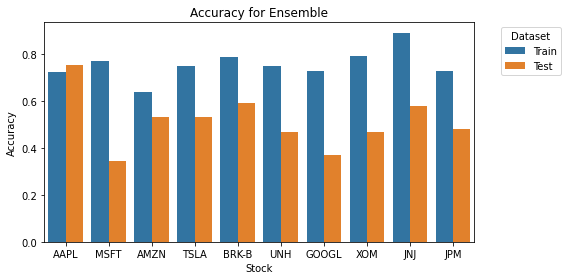

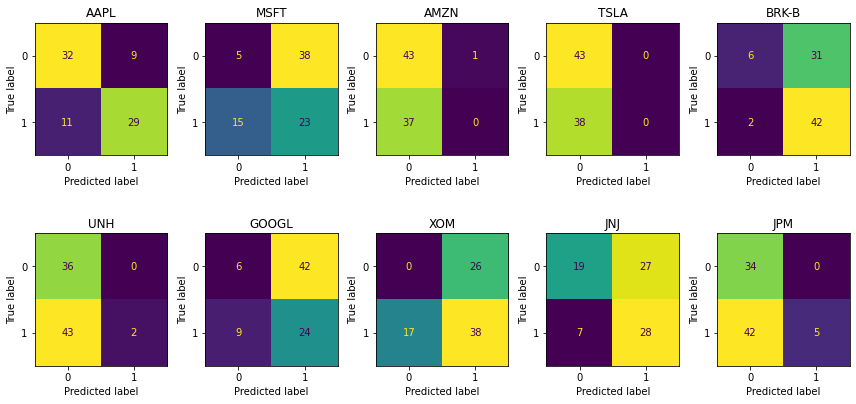

In [ ]:
svm_models_5d = [metrics_5d['best_estimator'] for metrics_5d in all_metrics_svc['5_day_metrics']]
ensemble_models_5d, ensemble_data_5d = generate_ensemble_models(
      '5d', 
      svm_models_5d,
      models_random_forest_5d,
      models_xgb_5d,
      lr_models_5d)
generate_ensemble_plots('5d', ensemble_models_5d, ensemble_data_5d)

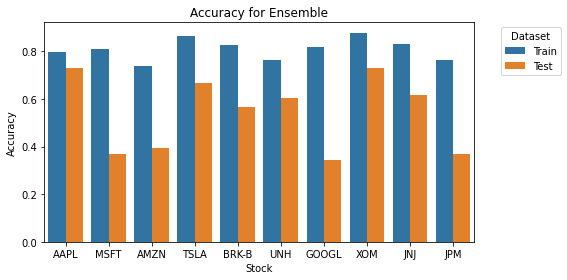

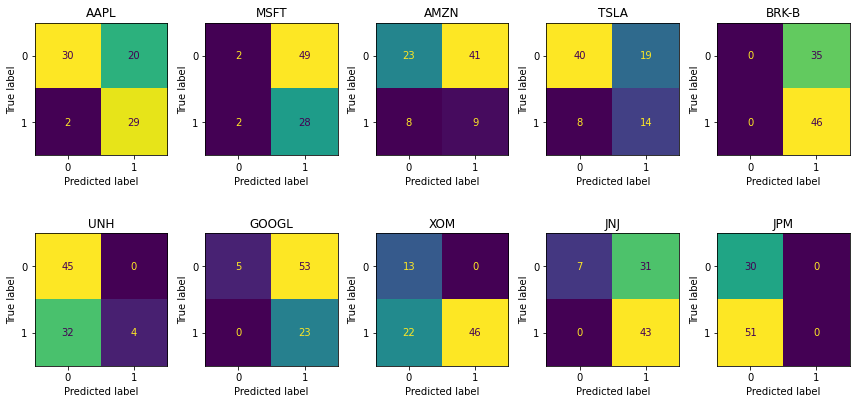

In [ ]:
svm_models_20d = [metrics_20d['best_estimator'] for metrics_20d in all_metrics_svc['20_day_metrics']]
ensemble_models_20d, ensemble_data_20d = generate_ensemble_models(
      '20d', 
      svm_models_20d,
      models_random_forest_20d,
      models_xgb_20d,
      lr_models_20d)
generate_ensemble_plots('20d', ensemble_models_20d, ensemble_data_20d)